<a href="https://colab.research.google.com/github/gongx030/seatac_manuscript/blob/main/notebooks/Etv2_MEF_histone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring the histone code changes on differential V-plots in Etv2 data

## Background

Reviewer #1's Issue #1. The paper would be far more useful/convincing for biologists if it included a series of browser views for the sites that are detected with seATAC but not with other procedures in order to inform on the validity of the interpretations.

Reviewer #1's Issue #2: Further, as SeATAC appears to be unique in documenting decreased chromatin accessibility at promoters of regulated genes, this aspect would be particularly interesting to biologists and browser views would be very helpful to convince the readers. To be really helpful, these browser views should include other typical marks of promoters and enhancers such as H3K4me3, H3K4me1, H3K27ac, etc.

## Tasks

* Examine Etv2 motifs during the ATAC-seq of Etv2 induced reprogramming
* Generate a list of browser view of Etv2 motifs with differential V-plots, histone codes and NucleoATAC signals

## Setup

### MSI Parition

```salloc --nodes=1 --ntasks-per-node=16 --mem=64gb -t 24:00:00 -p interactive```

### Conda

```r421_py37_tf26```

### Install R packages

In [ ]:
required_packages <- c(
  'BiocManager', 'devtools', 'Matrix',
  'dplyr', 'tidyr', 'stringr',
  'pROC', 'irlba',
  'chromVAR', 'chromVARmotifs', 'motifmatchr',
  'ChIPseeker', 'TxDb.Mmusculus.UCSC.mm10.knownGene', 'ChIPpeakAnno'
)

In [ ]:
missing_packages <- required_packages[!required_packages %in% rownames(installed.packages())]
if (length(missing_packages) > 0){
    BiocManager::install(missing_packages)
}

In [ ]:
for (p in required_packages){
  library(p, character.only  = TRUE)
}

Bioconductor version '3.15' is out-of-date; the current release version '3.16'
  is available with R version '4.2'; see https://bioconductor.org/install

Loading required package: usethis


Attaching package: ‘devtools’


The following object is masked from ‘package:BiocManager’:

    install


Warning message:
“package ‘Matrix’ was built under R version 4.2.2”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack


Warning message:
“package ‘stringr’ was built under R version 4.2.2”
Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




ChIPseeker v1.32.1  For help: https://guangchuangyu.github.io/software/ChIPseeker

If you use ChIPsee

### Install SeATAC from github

In [ ]:
#devtools::install('../seatac')
#install_github('gongx030/seatac@v0.4.0', force = TRUE, quiet = FALSE)

In [ ]:
#reload(pkgload::inst("seatac"))
#library(seatac)

In [ ]:
devtools::load_all('../seatac')

ℹ Loading seatac
Loading required package: tensorflow

Warning message:
"package 'tensorflow' was built under R version 4.2.2"
Loading required package: tfprobability

Loading required package: tfdatasets

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: 'matrixStats'


The following objects are masked from 'package:Biobase':

    anyMissing, rowMedians


The following object is masked from 'package:dplyr':

    count



Attaching package: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colV

### Load `tfa`

Required for `tfa.image.gaussian_filter2d`

In [ ]:
tfa <- reticulate::import('tensorflow_addons')

### Load bpt

In [ ]:
devtools::load_all('../bpt')

ℹ Loading bpt
Warning message:
"replacing previous import 'GenomicRanges::union' by 'dplyr::union' when loading 'bpt'"
Warning message:
"replacing previous import 'GenomicRanges::intersect' by 'dplyr::intersect' when loading 'bpt'"
Warning message:
"replacing previous import 'GenomicRanges::setdiff' by 'dplyr::setdiff' when loading 'bpt'"


## Parameters

In [ ]:
set.seed(123)

In [ ]:
ARGS <- list(

  remote_bam_files = c(
    'MEF_NoDox' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_NoDox.bam',
    'MEF_Dox_D1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D1.bam',
    'MEF_Dox_D2' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D2.bam',
    'MEF_Dox_D7' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7.bam',
    'MEF_Dox_D7_Flk1pos' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_Flk1pos.bam'
  ), 
  remote_bw_files = c(
    'MEF_Dox_D1_Etv2' 	= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d1_Etv2_FE.bw',
  	'MEF_Dox_D2_Etv2' 	= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d2_Etv2_FE.bw',
	  'MEF_Dox_D7_Etv2' 	= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d7_Etv2_FE.bw',
	  'MEF_NoDox_Brg1' 										= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_NoDox_d0_Brg1_FE.bw',
	  'MEF_Dox_D1_Brg1' 									= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d1_Brg1_FE.bw',
    'MEF_Dox_D2_Brg1' 									= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d2_Brg1_FE.bw',
	  'MEF_Dox_D7_Brg1' 									= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d7_Brg1_FE.bw',
    'MEF_NoDox_H3K27ac' 								= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_NoDox_d0_H3K27ac_FE.bw',
    'MEF_Dox_D1_H3K27ac' 								= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d1_H3K27ac_FE.bw',
    'MEF_Dox_D2_H3K27ac' 								= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d2_H3K27ac_FE.bw',
    'MEF_Dox_D7_H3K27ac' 								= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d7_H3K27ac_FE.bw',
    'MEF_NoDox_nucleoatac' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_NoDox.nucleoatac_signal.smooth.bw',
    'MEF_Dox_D1_nucleoatac' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D1.nucleoatac_signal.smooth.bw',
    'MEF_Dox_D2_nucleoatac' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D2.nucleoatac_signal.smooth.bw',
    'MEF_Dox_D7_nucleoatac' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7.nucleoatac_signal.smooth.bw',
    'MEF_Dox_D7_Flk1pos_nucleoatac' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_Flk1pos.nucleoatac_signal.smooth.bw',
    'MEF_NoDox_pileup' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_NoDox_treat_pileup.bw',
    'MEF_Dox_D1_pileup' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D1_treat_pileup.bw',
    'MEF_Dox_D2_pileup' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D2_treat_pileup.bw',
    'MEF_Dox_D7_pileup' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_treat_pileup.bw',
    'MEF_Dox_D7_Flk1pos_pileup' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_Flk1pos_treat_pileup.bw'

  ),
  genome_version = 'mm10',
  block_size = 640L,
  latent_dim = 10L,
  min_reads_train_seatac = 5L,  # minimum reads in blocks to train SeATAC
  min_reads_train_histone = 5L,  # minimum reads in blocks to train histone model
  min_reads_test_histone = 5L, # minimum reads in blocks to test histone model
  step_size = 200L,
  fragment_size_range_max = 640L,
  bin_size = 5L,
  fragment_size_interval = 10L,
  window_size = 2000L,
  sliding_step = 10L,
  max_peaks_train_seatac = 2000L, # maximum peaks per sample for training SeATAC
  max_peaks_count_reads = 10000L,  # maximum peaks for counting reads
  max_peaks_train_histone = 50000L, # maximum peaks for training histone model
  max_peaks_test_histone = 20000L, # maximum peaks for testing histone model
  batch_size = 128L,
  epochs = 200L,
  validation_split = 0.2,
  min_histone_signal_train = 100,
  min_histone_signal_test = 10,
  window_browser = 2001

)

In [ ]:
ARGS$local_bam_files <- gsub('https://', './', ARGS$remote_bam_files)

In [ ]:
ARGS$local_bw_files <- gsub('https://', './', ARGS$remote_bw_files)

In [ ]:
ARGS$remote_summit_files <- gsub('.bam', '_summits.bed', ARGS$remote_bam_files)
ARGS$local_summit_files <- gsub('https://', './', ARGS$remote_summit_files)

In [ ]:
ARGS$remote_nucleoatac_files <- gsub('.bam', '.nucleoatac_signal.smooth.bw', ARGS$remote_bam_files)
ARGS$local_nucleoatac_files <- gsub('https://', './', ARGS$remote_nucleoatac_files)

In [ ]:
ARGS$remote_macs2_files <- gsub('.bam', '_treat_pileup.bw', ARGS$remote_bam_files)
ARGS$local_macs2_files <- gsub('https://', './', ARGS$remote_macs2_files)

## `plot_track`

In [ ]:
plot_track <- function(x2){

rbind(
  data.frame(signal = rowData(x2)$MEF_NoDox_pileup %>% colMeans() %>% as.numeric(), position = 1:ARGS$window_browser - floor(ARGS$window_browser / 2), type = 'Pileup', group = 'MEF'),
  data.frame(signal = rowData(x2)$MEF_Dox_D1_pileup %>% colMeans()%>% as.numeric(), position = 1:ARGS$window_browser - floor(ARGS$window_browser / 2), type = 'Pileup', group = 'D1'),
  data.frame(signal = rowData(x2)$MEF_Dox_D2_pileup %>% colMeans()%>% as.numeric(), position = 1:ARGS$window_browser - floor(ARGS$window_browser / 2), type = 'Pileup', group = 'D2'),
  data.frame(signal = rowData(x2)$MEF_Dox_D7_pileup %>% colMeans()%>% as.numeric(), position = 1:ARGS$window_browser - floor(ARGS$window_browser / 2), type = 'Pileup', group = 'D7'),
  data.frame(signal = rowData(x2)$MEF_Dox_D7_Flk1pos_pileup %>% colMeans()%>% as.numeric(), position = 1:ARGS$window_browser - floor(ARGS$window_browser / 2), type = 'Pileup', group = 'D7_Flk1+'),

  data.frame(signal = rowData(x2)$MEF_NoDox_nucleoatac %>% colMeans()%>% as.numeric() + 0.05, position = 1:ARGS$window_browser - floor(ARGS$window_browser / 2), type = 'NucleoATAC', group = 'MEF'),
  data.frame(signal = rowData(x2)$MEF_Dox_D1_nucleoatac %>% colMeans()%>% as.numeric() + 0.05, position = 1:ARGS$window_browser - floor(ARGS$window_browser / 2), type = 'NucleoATAC', group = 'D1'),
  data.frame(signal = rowData(x2)$MEF_Dox_D2_nucleoatac %>% colMeans()%>% as.numeric() + 0.05, position = 1:ARGS$window_browser - floor(ARGS$window_browser / 2), type = 'NucleoATAC', group = 'D2'),
  data.frame(signal = rowData(x2)$MEF_Dox_D7_nucleoatac %>% colMeans()%>% as.numeric() + 0.05, position = 1:ARGS$window_browser - floor(ARGS$window_browser / 2), type = 'NucleoATAC', group = 'D7'),
  data.frame(signal = rowData(x2)$MEF_Dox_D7_Flk1pos_nucleoatac %>% colMeans()%>% as.numeric() + 0.05, position = 1:ARGS$window_browser - floor(ARGS$window_browser / 2), type = 'NucleoATAC', group = 'D7_Flk1+'),

  data.frame(signal = rowData(x2)$MEF_Dox_D1_Etv2 %>% colMeans()%>% as.numeric() + 0.2, position = 1:ARGS$window_browser - floor(ARGS$window_browser / 2), type = 'Etv2', group = 'D1'),
  data.frame(signal = rowData(x2)$MEF_Dox_D2_Etv2 %>% colMeans()%>% as.numeric() + 0.2, position = 1:ARGS$window_browser - floor(ARGS$window_browser / 2), type = 'Etv2', group = 'D2'),
  data.frame(signal = rowData(x2)$MEF_Dox_D7_Etv2 %>% colMeans()%>% as.numeric() + 0.2, position = 1:ARGS$window_browser - floor(ARGS$window_browser / 2), type = 'Etv2', group = 'D7'),

  data.frame(signal = rowData(x2)$MEF_NoDox_H3K27ac %>% colMeans()%>% as.numeric(), position = 1:ARGS$window_browser - floor(ARGS$window_browser / 2), type = 'H3K27ac', group = 'MEF'),
  data.frame(signal = rowData(x2)$MEF_Dox_D1_H3K27ac %>% colMeans()%>% as.numeric(), position = 1:ARGS$window_browser - floor(ARGS$window_browser / 2), type = 'H3K27ac', group = 'D1'),
  data.frame(signal = rowData(x2)$MEF_Dox_D2_H3K27ac %>% colMeans()%>% as.numeric(), position = 1:ARGS$window_browser - floor(ARGS$window_browser / 2), type = 'H3K27ac', group = 'D2'),
  data.frame(signal = rowData(x2)$MEF_Dox_D7_H3K27ac %>% colMeans()%>% as.numeric(), position = 1:ARGS$window_browser - floor(ARGS$window_browser / 2), type = 'H3K27ac', group = 'D7'),

  data.frame(signal = rowData(x2)$MEF_NoDox_Brg1 %>% colMeans()%>% as.numeric(), position = 1:ARGS$window_browser - floor(ARGS$window_browser / 2), type = 'Brg1', group = 'MEF'),
  data.frame(signal = rowData(x2)$MEF_Dox_D1_Brg1 %>% colMeans()%>% as.numeric(), position = 1:ARGS$window_browser - floor(ARGS$window_browser / 2), type = 'Brg1', group = 'D1'),
  data.frame(signal = rowData(x2)$MEF_Dox_D2_Brg1 %>% colMeans()%>% as.numeric(), position = 1:ARGS$window_browser - floor(ARGS$window_browser / 2), type = 'Brg1', group = 'D2'),
  data.frame(signal = rowData(x2)$MEF_Dox_D7_Brg1 %>% colMeans()%>% as.numeric(), position = 1:ARGS$window_browser - floor(ARGS$window_browser / 2), type = 'Brg1', group = 'D7')

) %>%
  mutate(group = factor(group, c('MEF', 'D1', 'D2', 'D7', 'D7_Flk1+'))) %>%
  mutate(type = factor(type, c('Pileup', 'NucleoATAC', 'Etv2', 'Brg1', 'H3K27ac'))) %>% 
  ggplot(aes(x = position, y = signal, fill = type)) +
    geom_area() +
    facet_grid(type ~ group, scales = 'free', drop = TRUE) +
    scale_x_continuous(
      breaks = as.integer(c(-ARGS$block_size / 2, 0, ARGS$block_size / 2)),
      expand = c(0, 0)
    ) +
    scale_fill_manual(values = c('Pileup' = 'darkgray', 'NucleoATAC' = 'black', 'H3K27ac' = 'darkgreen', 'Brg1' = 'purple', 'Etv2' = 'red')) +
    theme_bw() +
    theme(
      axis.line = element_line(colour = "black"),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      panel.background = element_blank(),
      axis.text = element_text(size = 15),
      axis.title = element_text(size = 15),
      strip.text.x = element_text(size = 15),
      strip.text.y = element_text(size = 15)
    ) +
    geom_vline(xintercept = 0, linetype = 'dotted') +
    geom_vline(xintercept = c(-ARGS$block_size / 2, ARGS$block_size / 2), linetype = 'dotted', color = 'red') +
    xlab('Positions relative to Etv2 motif') + ylab('Density')
}

## Download files

### BAM files

In [ ]:
download_remote_file(ARGS$remote_bam_files)

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_NoDox.bam

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D1.bam

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D2.bam

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7.bam

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_Flk1pos.bam



In [ ]:
stopifnot(all(file.exists(ARGS$local_bam_files)))

### Summit files

In [ ]:
download_remote_file(ARGS$remote_summit_files)

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_NoDox_summits.bed

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D1_summits.bed

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D2_summits.bed

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_summits.bed

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_Flk1pos_summits.bed



In [ ]:
stopifnot(file.exists(ARGS$local_summit_files))

### bigwig files

In [ ]:
download_remote_file(ARGS$remote_bw_files)

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d1_Etv2_FE.bw

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d2_Etv2_FE.bw

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d7_Etv2_FE.bw

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_NoDox_d0_Brg1_FE.bw

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d1_Brg1_FE.bw

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d2_Brg1_FE.bw

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d7_Brg1_FE.bw

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_NoDox_d0_H3K27ac_FE.bw

wget -cx https://s3.msi.umn.edu/gongx030/datasets

In [ ]:
stopifnot(file.exists(ARGS$local_bw_files))

## Read summits for training SeATAC

In [ ]:
gr0 <- lapply(ARGS$local_summit_file, function(bed_file){
  sprintf('reading %s', bed_file) %>% message()
  peaks <- read.table(bed_file, header = FALSE, sep = '\t')
  peaks <- GRanges(seqnames = peaks[, 1], range = IRanges(start = peaks[, 2], end = peaks[, 3]))
  peaks <- resize(peaks, fix = 'center', width = ARGS$step_size)
  peaks
}) %>%
  GRangesList() %>%
  coverage() %>%
  IRanges::slice(lower = 1, rangesOnly = TRUE) %>%
  GRanges() %>%
  resize(fix = 'center', width = ARGS$window_size)
gr0 <- gr0[seqnames(gr0) %in% sprintf('chr%s', c(1:22, 'X'))]
seqlevels(gr0) <- seqlevels(seqinfo(get_bsgenome(ARGS$genome_version)))
seqinfo(gr0, pruning.mode = 'coarse') <- seqinfo(get_bsgenome(ARGS$genome_version))

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_NoDox_summits.bed

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D1_summits.bed

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D2_summits.bed

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_summits.bed

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_Flk1pos_summits.bed

Loading required package: BSgenome.Mmusculus.UCSC.mm10

Loading required package: BSgenome

Loading required package: Biostrings

Loading required package: XVector


Attaching package: 'Biostrings'


The following object is masked from 'package:base':

    strsplit


Loading required package: rtracklayer

Loading required package: BSgenome.Hsapiens.UCSC.hg19



In [ ]:
gr0 <- trim(gr0)

In [ ]:
gr <- slidingWindows(gr0, width = ARGS$block_size, step = ARGS$bin_size) %>% unlist()
sprintf('total blocks: %d', length(gr)) %>% message()
gr <- sample(gr, min(length(gr), ARGS$max_peaks_count_reads))
sprintf('total blocks for training: %d', length(gr)) %>% message()

total blocks: 21570822

total blocks for training: 10000



In [ ]:
counts <- count_reads(gr, ARGS$local_bam_files, genome = get_bsgenome(ARGS$genome_version),  fragment_size_range = c(0, ARGS$fragment_size_range_max))

read_bam | reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_NoDox.bam

read_bam | reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D1.bam

read_bam | reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D2.bam

read_bam | reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7.bam

read_bam | reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_Flk1pos.bam



In [ ]:
valid <- rowSums(counts >= ARGS$min_reads_train_seatac) == ncol(counts)
sprintf('number of valid peaks for VaeModel(>=%d reads): %d', ARGS$min_reads_train_seatac, sum(valid)) %>% message()
gr <- gr[valid]

number of valid peaks for VaeModel(>=5 reads): 9432



In [ ]:
x <- read_vplot(
  gr,
  filenames = ARGS$local_bam_files, 
  genome = get_bsgenome(ARGS$genome_version),
  bin_size = ARGS$bin_size,
  fragment_size_range = c(0, ARGS$fragment_size_range_max),
  fragment_size_interval = ARGS$fragment_size_interval
)

read_bam | reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_NoDox.bam

Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr1_GL455991_alt, chr1_GL455992_alt, chr1_GL455993_alt, chr1_GL456005_alt, chr1_JH584315_alt, chr1_JH584320_alt, chr1_JH584321_alt, chr1_JH584322_alt, chr2_GL456024_alt, chr3_GL456006_alt, chr3_GL456007_alt, chr3_GL456008_alt, chr3_GL456042_alt, chr3_GL456044_alt, chr3_GL456045_alt, chr3_GL456048_alt, chr3_GL456049_alt, chr3_JH584323_alt, chr4_GL455994_alt, chr4_GL456009_alt, chr4_GL456010_alt, chr4_GL456053_alt, chr4_GL456064_alt, chr4_GL456075_alt, chr4_GL456076_alt, chr4_GL456077_alt, chr4_JH584268_alt, chr4_JH584269_alt, chr4_JH584324_alt, chr4_JH584325_alt, chr4_JH584326_alt, chr5_GL455995_alt, chr5_GL456011_alt, chr6_GL456012_alt, chr6_GL456025_alt, chr6_GL456026_alt, chr6_GL456054_alt, chr6_GL456065_alt, chr6_JH584264_alt, chr7_GL455989_alt, chr7_GL4560

## Training SeATAC

In [ ]:
model <- VaeModel(x, latent_dim = ARGS$latent_dim)

In [ ]:
model <- model %>% fit(x, batch_size = ARGS$batch_size, epochs = ARGS$epochs, compile = TRUE)

epoch=     1/   200 | beta=1.000e+00 | loss= 6449.9558567 | loss_reconstruction= 6448.7211518 | loss_kl=    1.2346849

epoch=     2/   200 | beta=1.000e+00 | loss= 5108.3424633 | loss_reconstruction= 5104.6497770 | loss_kl=    3.6926922

epoch=     3/   200 | beta=1.000e+00 | loss= 3950.7637906 | loss_reconstruction= 3949.7835495 | loss_kl=    0.9802351

epoch=     4/   200 | beta=1.000e+00 | loss= 2237.3903743 | loss_reconstruction= 2237.0509330 | loss_kl=    0.3394473

epoch=     5/   200 | beta=1.000e+00 | loss=  971.8362666 | loss_reconstruction=  971.7368758 | loss_kl=    0.0993883

epoch=     6/   200 | beta=1.000e+00 | loss=  479.4340614 | loss_reconstruction=  479.3771523 | loss_kl=    0.0569102

epoch=     7/   200 | beta=1.000e+00 | loss=  316.4786315 | loss_reconstruction=  316.3729718 | loss_kl=    0.1056583

epoch=     8/   200 | beta=1.000e+00 | loss=  255.1250938 | loss_reconstruction=  254.8182938 | loss_kl=    0.3067996

epoch=     9/   200 | beta=1.000e+00 | loss=  22

## Etv2 motifs in Etv2 pioneer data

In [ ]:
data('homer_pwms')

In [ ]:
j <- 82 # Etv2
homer_pwms[j]

PWMatrixList of length 1
names(1): Etv2(ETS)/ES-ER71-ChIP-Seq(GSE59402)/Homer(0.967)

In [ ]:
gr <- matchMotifs(homer_pwms[j], gr0, genome = BSgenome.Mmusculus.UCSC.mm10, out = 'positions')[[1]] %>%
  resize(width = ARGS$block_size, fix = 'center') %>%
  unique()

In [ ]:
sprintf('number of motif-centric regions: %s', length(gr)) %>% message()

number of motif-centric regions: 34849



In [ ]:
x <- read_vplot(
  gr,
  filenames = ARGS$local_bam_files, 
  genome = get_bsgenome(ARGS$genome_version),
  bin_size = ARGS$bin_size,
  fragment_size_range = c(0, ARGS$fragment_size_range_max),
  fragment_size_interval = ARGS$fragment_size_interval
)

read_bam | reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_NoDox.bam

Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr1_GL455991_alt, chr1_GL455992_alt, chr1_GL455993_alt, chr1_GL456005_alt, chr1_JH584315_alt, chr1_JH584320_alt, chr1_JH584321_alt, chr1_JH584322_alt, chr2_GL456024_alt, chr3_GL456006_alt, chr3_GL456007_alt, chr3_GL456008_alt, chr3_GL456042_alt, chr3_GL456044_alt, chr3_GL456045_alt, chr3_GL456048_alt, chr3_GL456049_alt, chr3_JH584323_alt, chr4_GL455994_alt, chr4_GL456009_alt, chr4_GL456010_alt, chr4_GL456053_alt, chr4_GL456064_alt, chr4_GL456075_alt, chr4_GL456076_alt, chr4_GL456077_alt, chr4_JH584268_alt, chr4_JH584269_alt, chr4_JH584324_alt, chr4_JH584325_alt, chr4_JH584326_alt, chr5_GL455995_alt, chr5_GL456011_alt, chr6_GL456012_alt, chr6_GL456025_alt, chr6_GL456026_alt, chr6_GL456054_alt, chr6_GL456065_alt, chr6_JH584264_alt, chr7_GL455989_alt, chr7_GL4560

In [ ]:
x <- model %>% seatac::predict(x, batch_size = ARGS$batch_size, vplots = TRUE)

## Read bigwig files

In [ ]:
gr_w <- resize(gr, width = ARGS$window_browser, fix = 'center')

In [ ]:
for (i in c(
  'MEF_NoDox_H3K27ac', 'MEF_Dox_D1_H3K27ac', 'MEF_Dox_D2_H3K27ac', 'MEF_Dox_D7_H3K27ac', 
  'MEF_Dox_D1_Etv2', 'MEF_Dox_D2_Etv2', 'MEF_Dox_D7_Etv2', 
  'MEF_NoDox_Brg1', 'MEF_Dox_D1_Brg1', 'MEF_Dox_D2_Brg1', 'MEF_Dox_D7_Brg1',
  'MEF_NoDox_nucleoatac', 'MEF_Dox_D1_nucleoatac', 'MEF_Dox_D2_nucleoatac', 'MEF_Dox_D7_nucleoatac', 'MEF_Dox_D7_Flk1pos_nucleoatac',
  'MEF_NoDox_pileup', 'MEF_Dox_D1_pileup', 'MEF_Dox_D2_pileup', 'MEF_Dox_D7_pileup', 'MEF_Dox_D7_Flk1pos_pileup'
)){
  sprintf('reading %s', ARGS$local_bw_files[i]) %>% message()
  cvg <- rtracklayer::import(ARGS$local_bw_files[i], which = gr_w)
  seqlengths(cvg) <- seqlengths(cvg) + ARGS$block_size
  cvg <- coverage(cvg, weight = 'score')
  y <- cvg[gr_w] %>% as.matrix()
  #y <- (y - rowMins(y)) / (rowMaxs(y) - rowMins(y))
  #y[is.na(y) | is.infinite(y)] <- 0
  rowData(x)[[i]] <- y
}

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_NoDox_d0_H3K27ac_FE.bw

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d1_H3K27ac_FE.bw

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d2_H3K27ac_FE.bw

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d7_H3K27ac_FE.bw

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d1_Etv2_FE.bw

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d2_Etv2_FE.bw

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d7_Etv2_FE.bw

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_NoDox_d0_Brg1_FE.bw

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_

## Plot significant NOR->NFR regions

In [ ]:
res <- model %>% results(x, type = 'vplots', contrast = c('name', 'MEF_NoDox', 'MEF_Dox_D7_Flk1pos'))
res$index <- 1:length(res)
res <- res[res$padj < 0.05]
res <- res[order(res$log_ratio)]

### chr17:57274896-57275535

In [ ]:
x2 <- x[seqnames(x) == 'chr17' & start(x) == 57274896]
sprintf('%s:%d-%d', seqnames(x2), start(x2), end(x2)) %>% message()

chr17:57274896-57275535



Warning message:
"Removed 320 rows containing missing values (`geom_raster()`)."
Warning message:
"Removed 320 rows containing missing values (`geom_raster()`)."


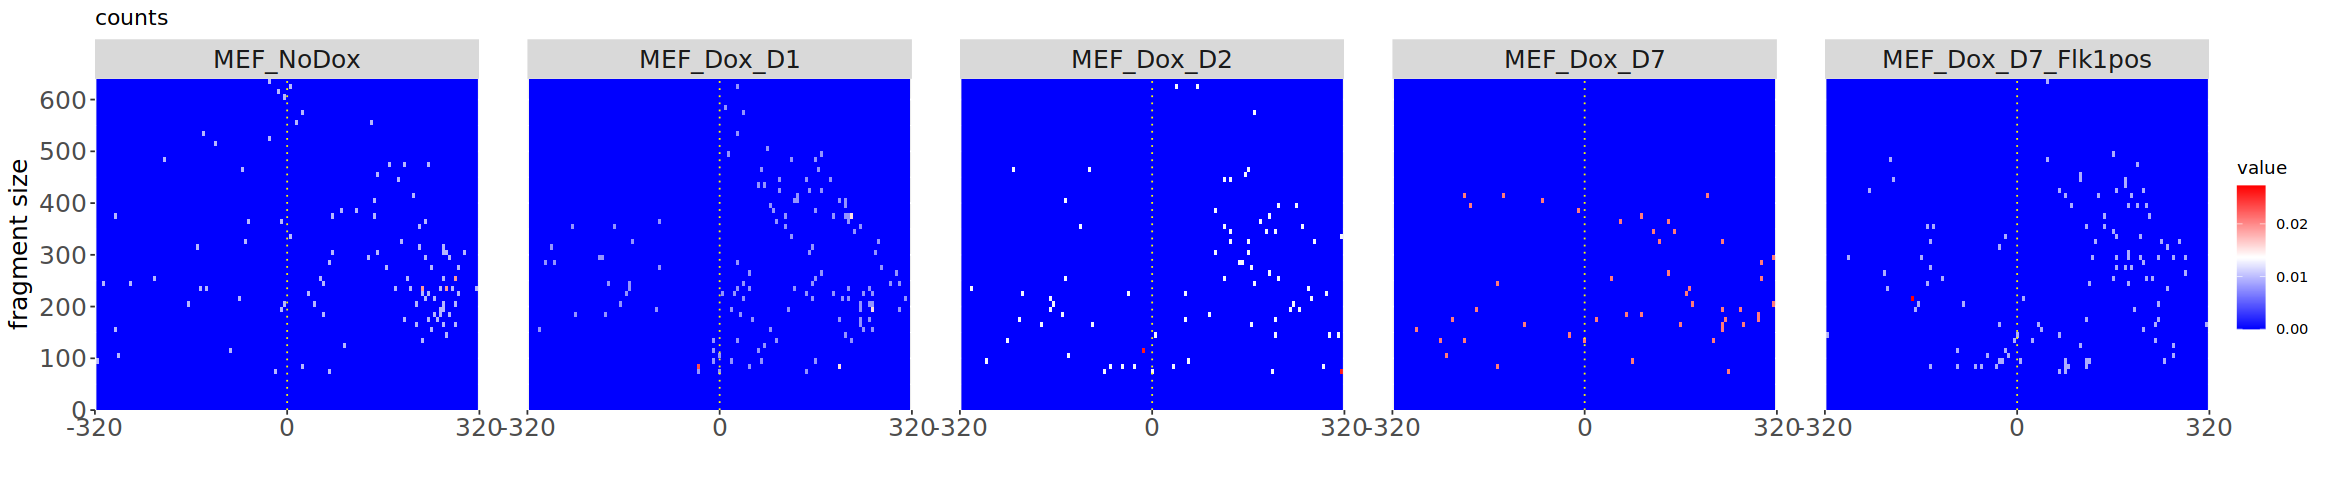

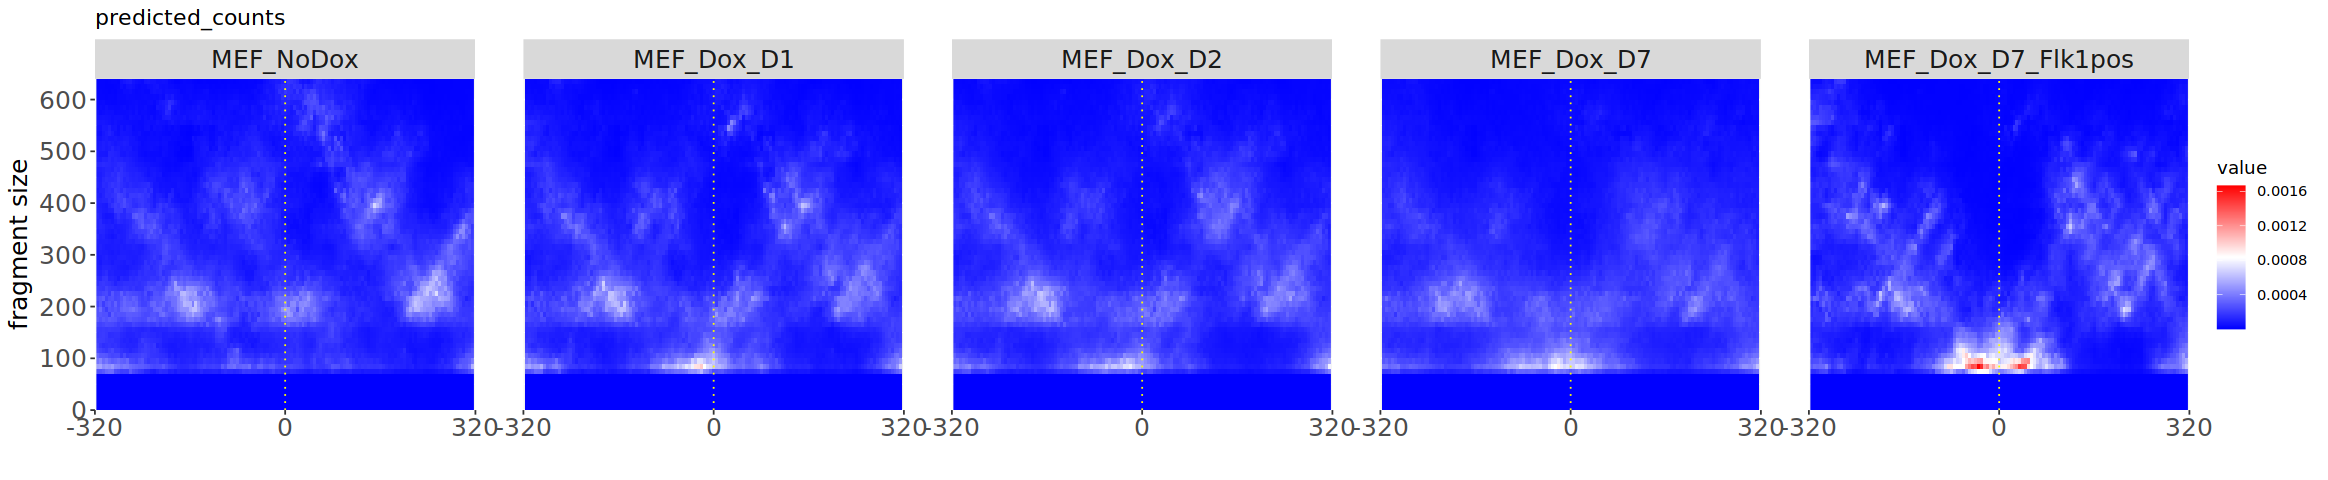

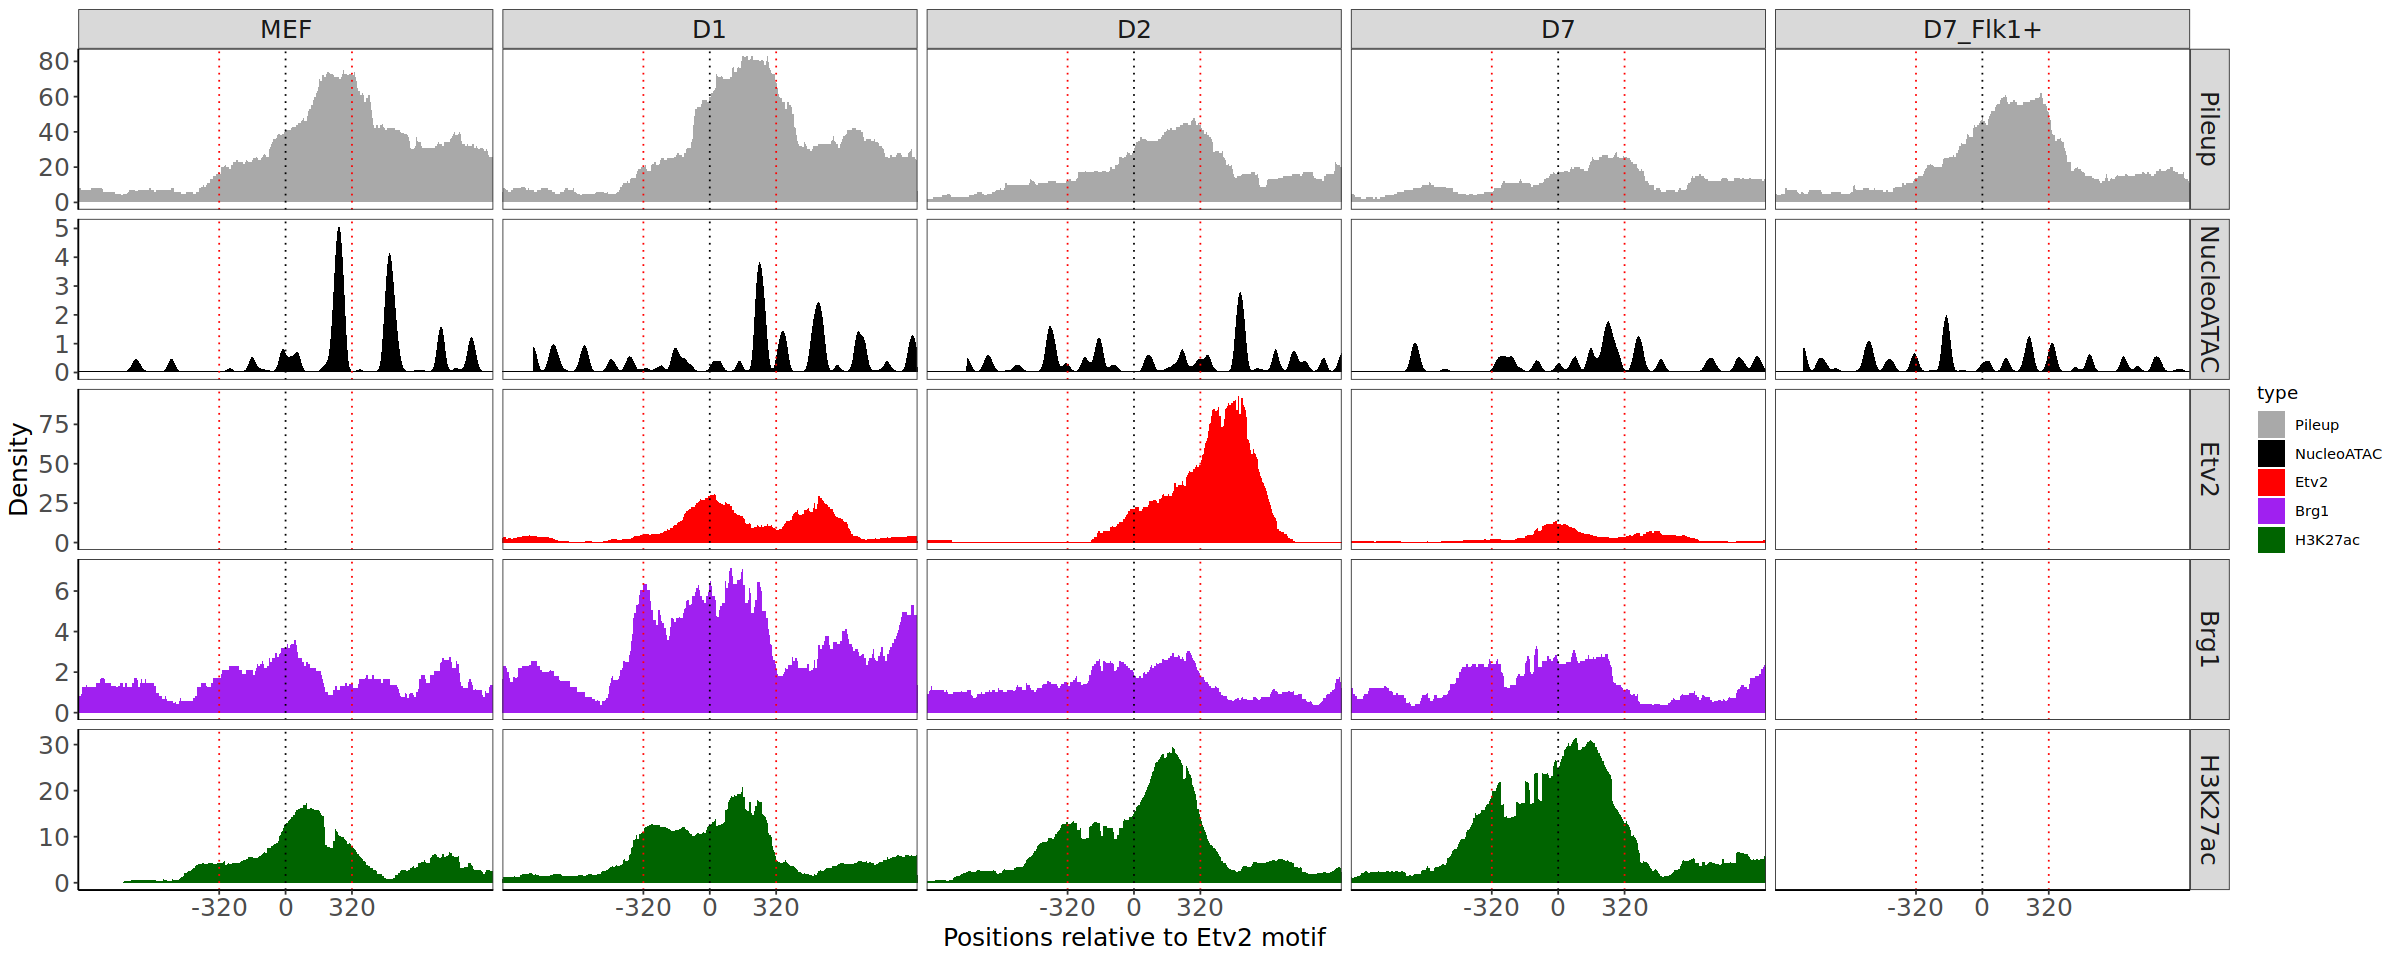

In [ ]:
options(repr.plot.width = 19.4, repr.plot.height = 4)
vplot(x2, 'counts', ncol = 5)
vplot(x2, 'predicted_counts', ncol = 5)
options(repr.plot.width = 20, repr.plot.height = 8)
plot_track(x2)

### chr14:7863942-7864581

In [ ]:
x2 <- x[seqnames(x) == 'chr14' & start(x) == 7863942]
sprintf('%s:%d-%d', seqnames(x2), start(x2), end(x2)) %>% message()

chr14:7863942-7864581



Warning message:
"Removed 320 rows containing missing values (`geom_raster()`)."
Warning message:
"Removed 320 rows containing missing values (`geom_raster()`)."


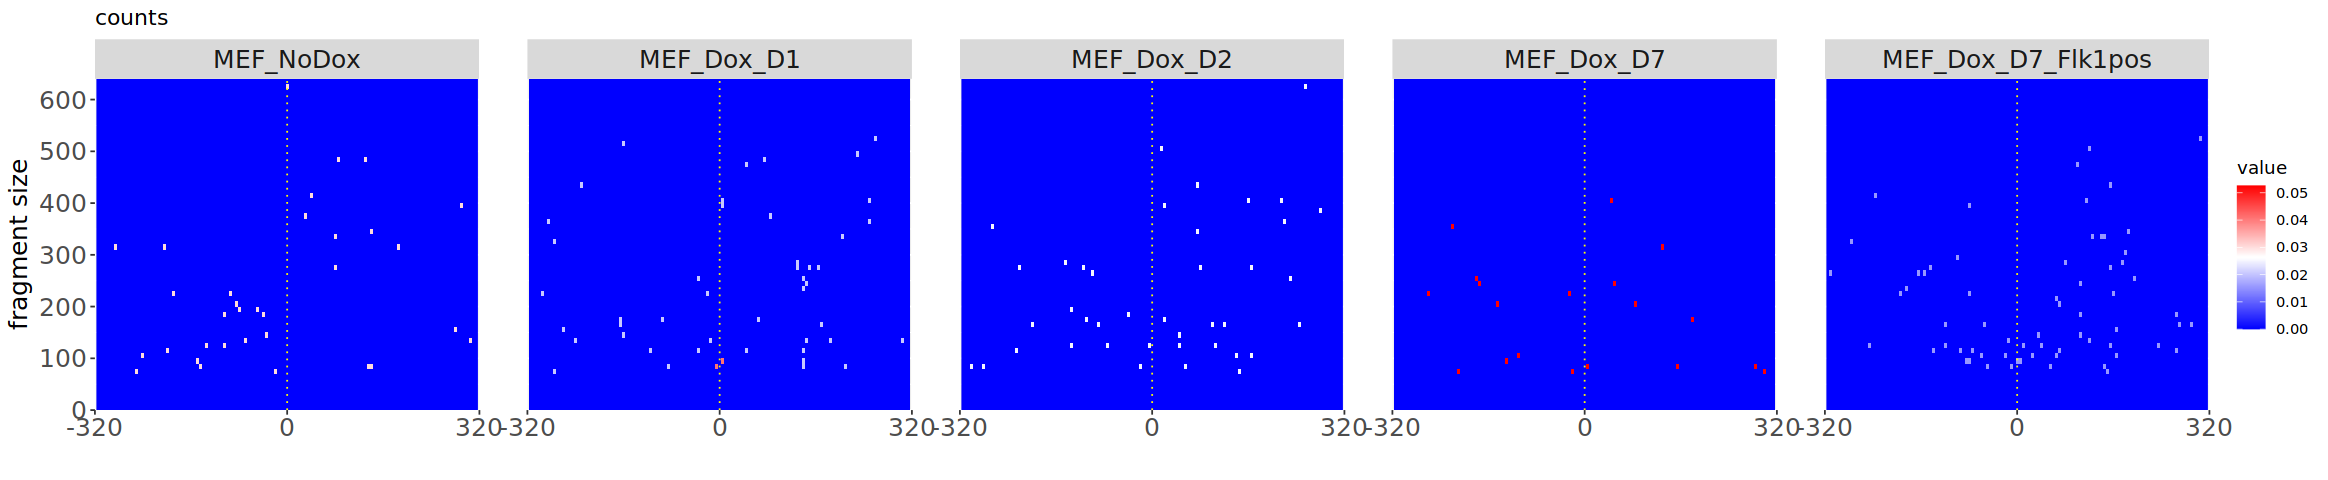

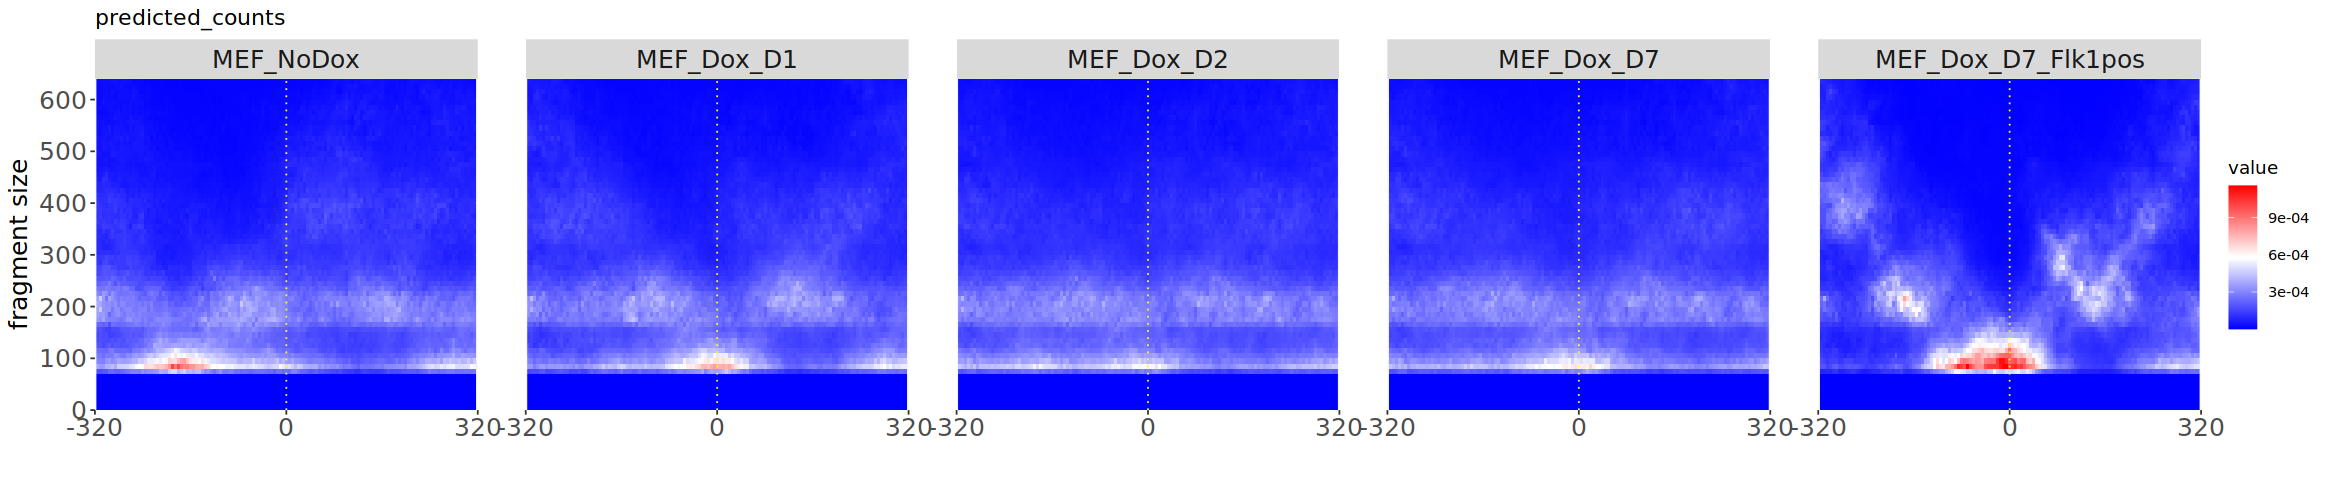

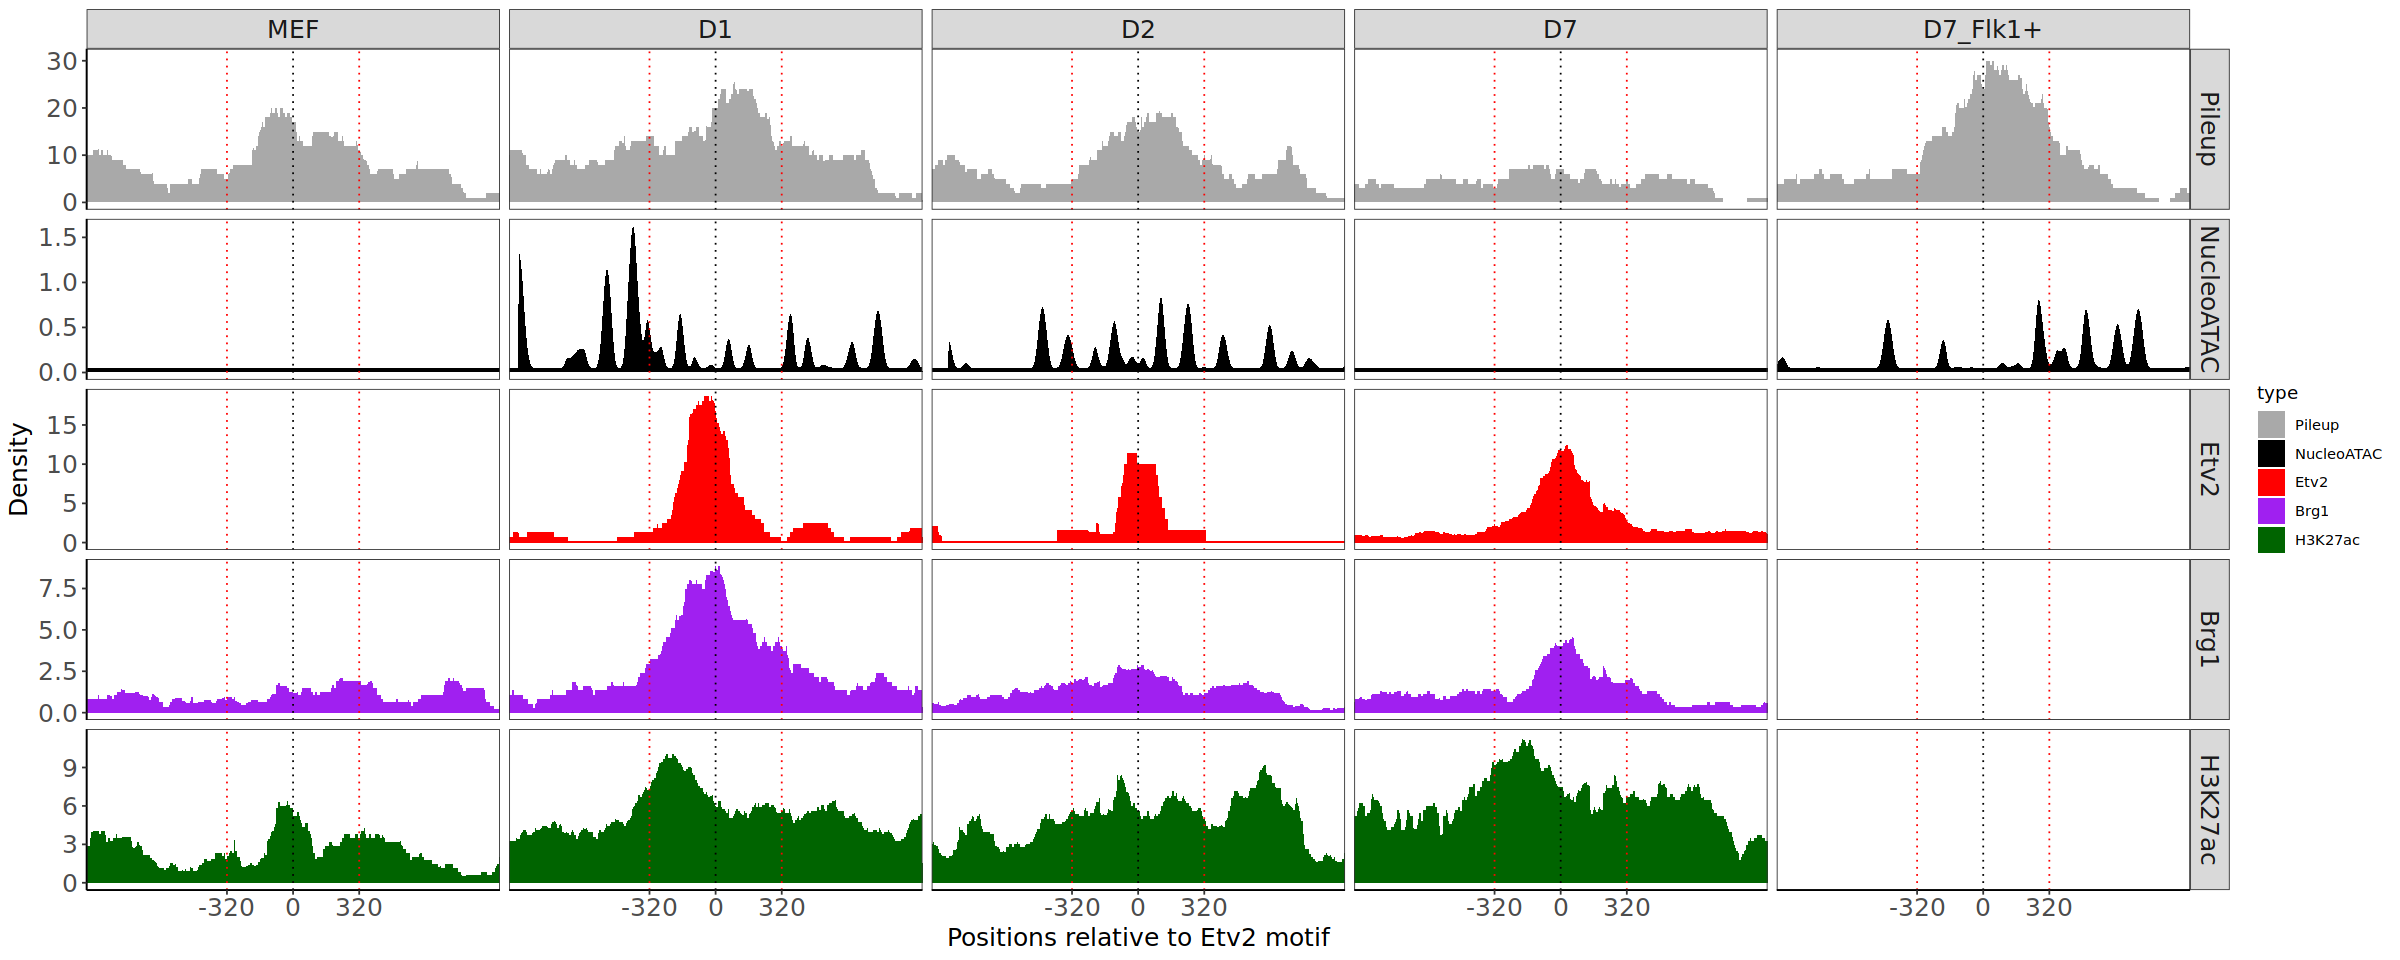

In [ ]:
options(repr.plot.width = 19.4, repr.plot.height = 4)
vplot(x2, 'counts', ncol = 5)
vplot(x2, 'predicted_counts', ncol = 5)
options(repr.plot.width = 20, repr.plot.height = 8)
plot_track(x2)

### chr18:70278167-70278806

In [ ]:
x2 <- x[seqnames(x) == 'chr18' & start(x) == 70278167]
sprintf('%s:%d-%d', seqnames(x2), start(x2), end(x2)) %>% message()

chr18:70278167-70278806



Warning message:
"Removed 320 rows containing missing values (`geom_raster()`)."
Warning message:
"Removed 320 rows containing missing values (`geom_raster()`)."


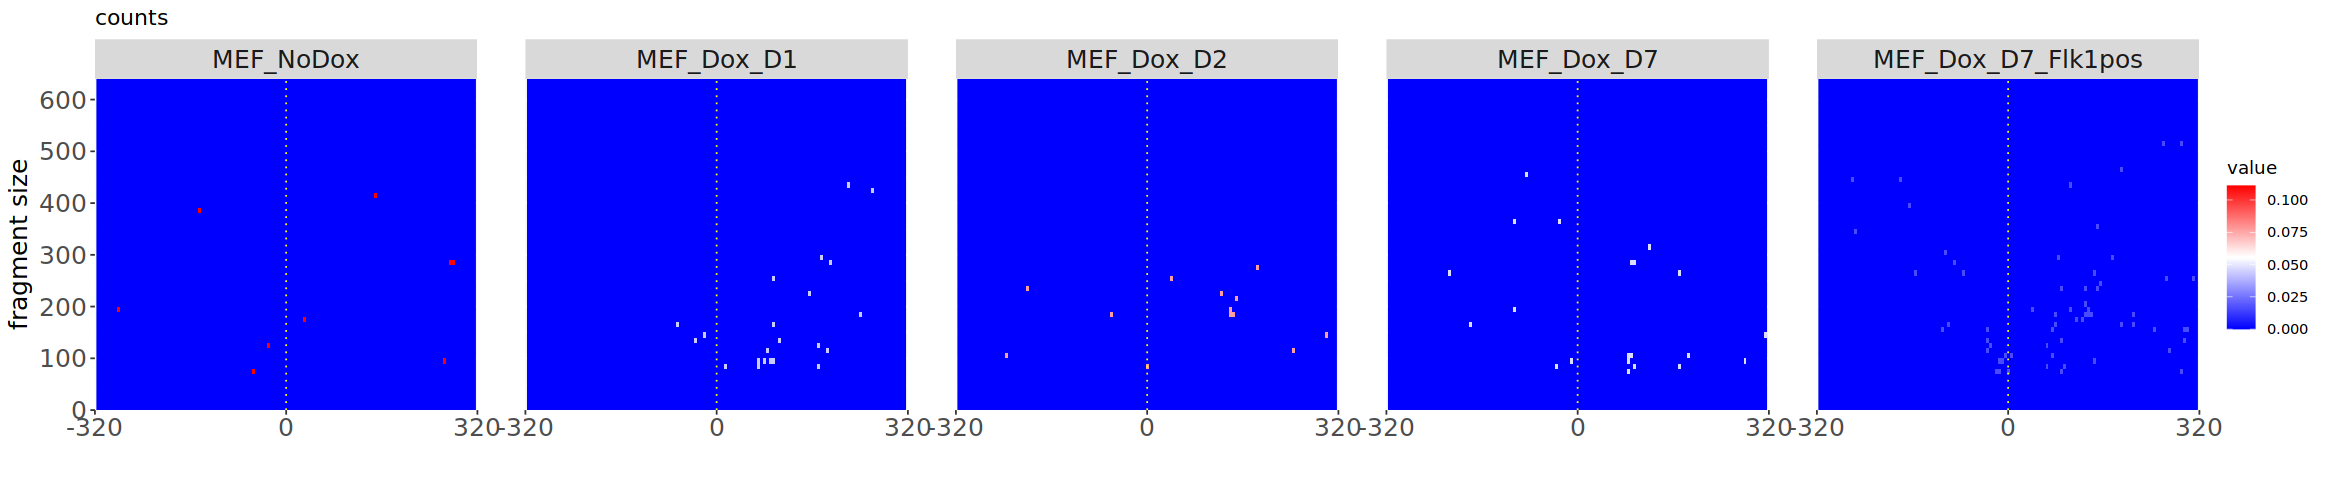

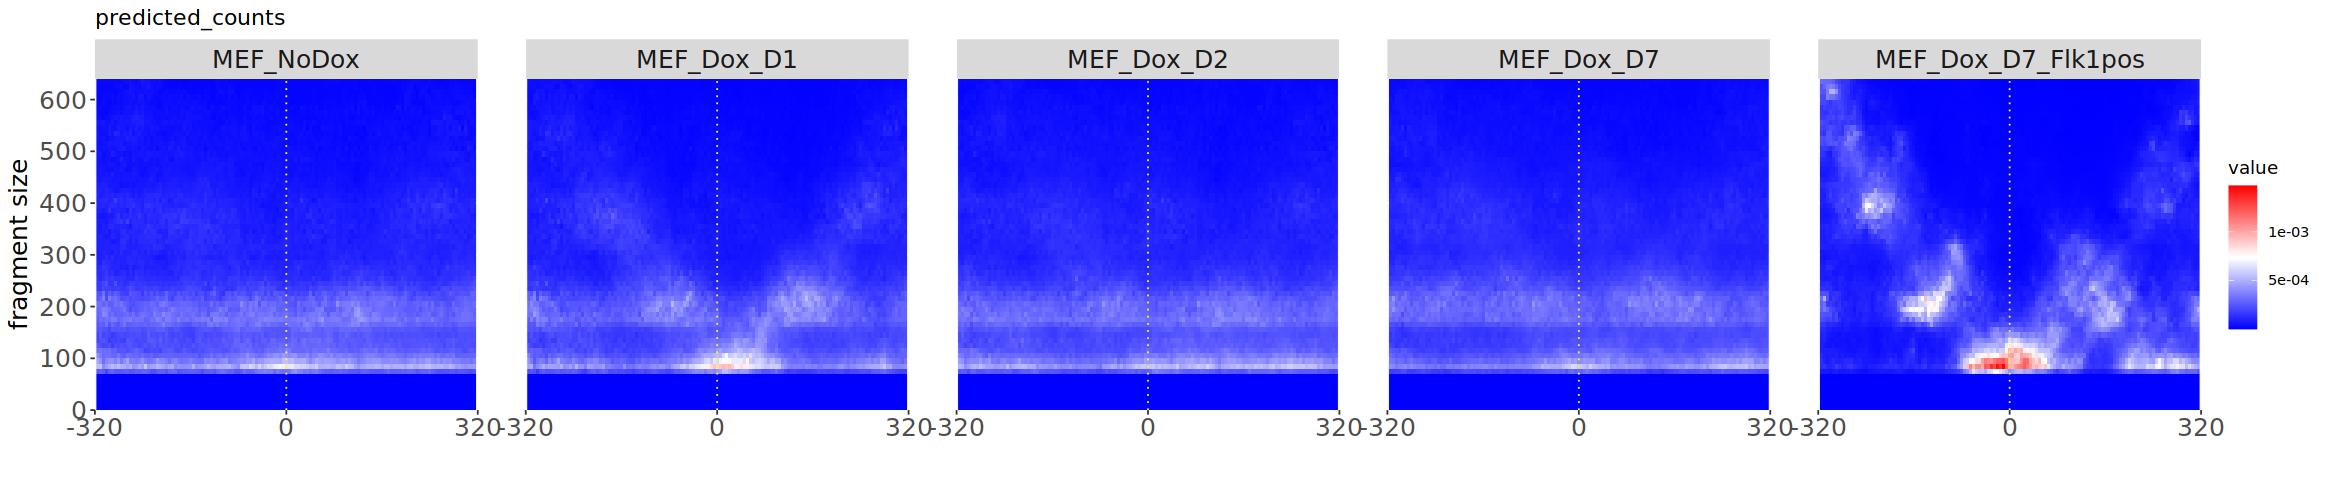

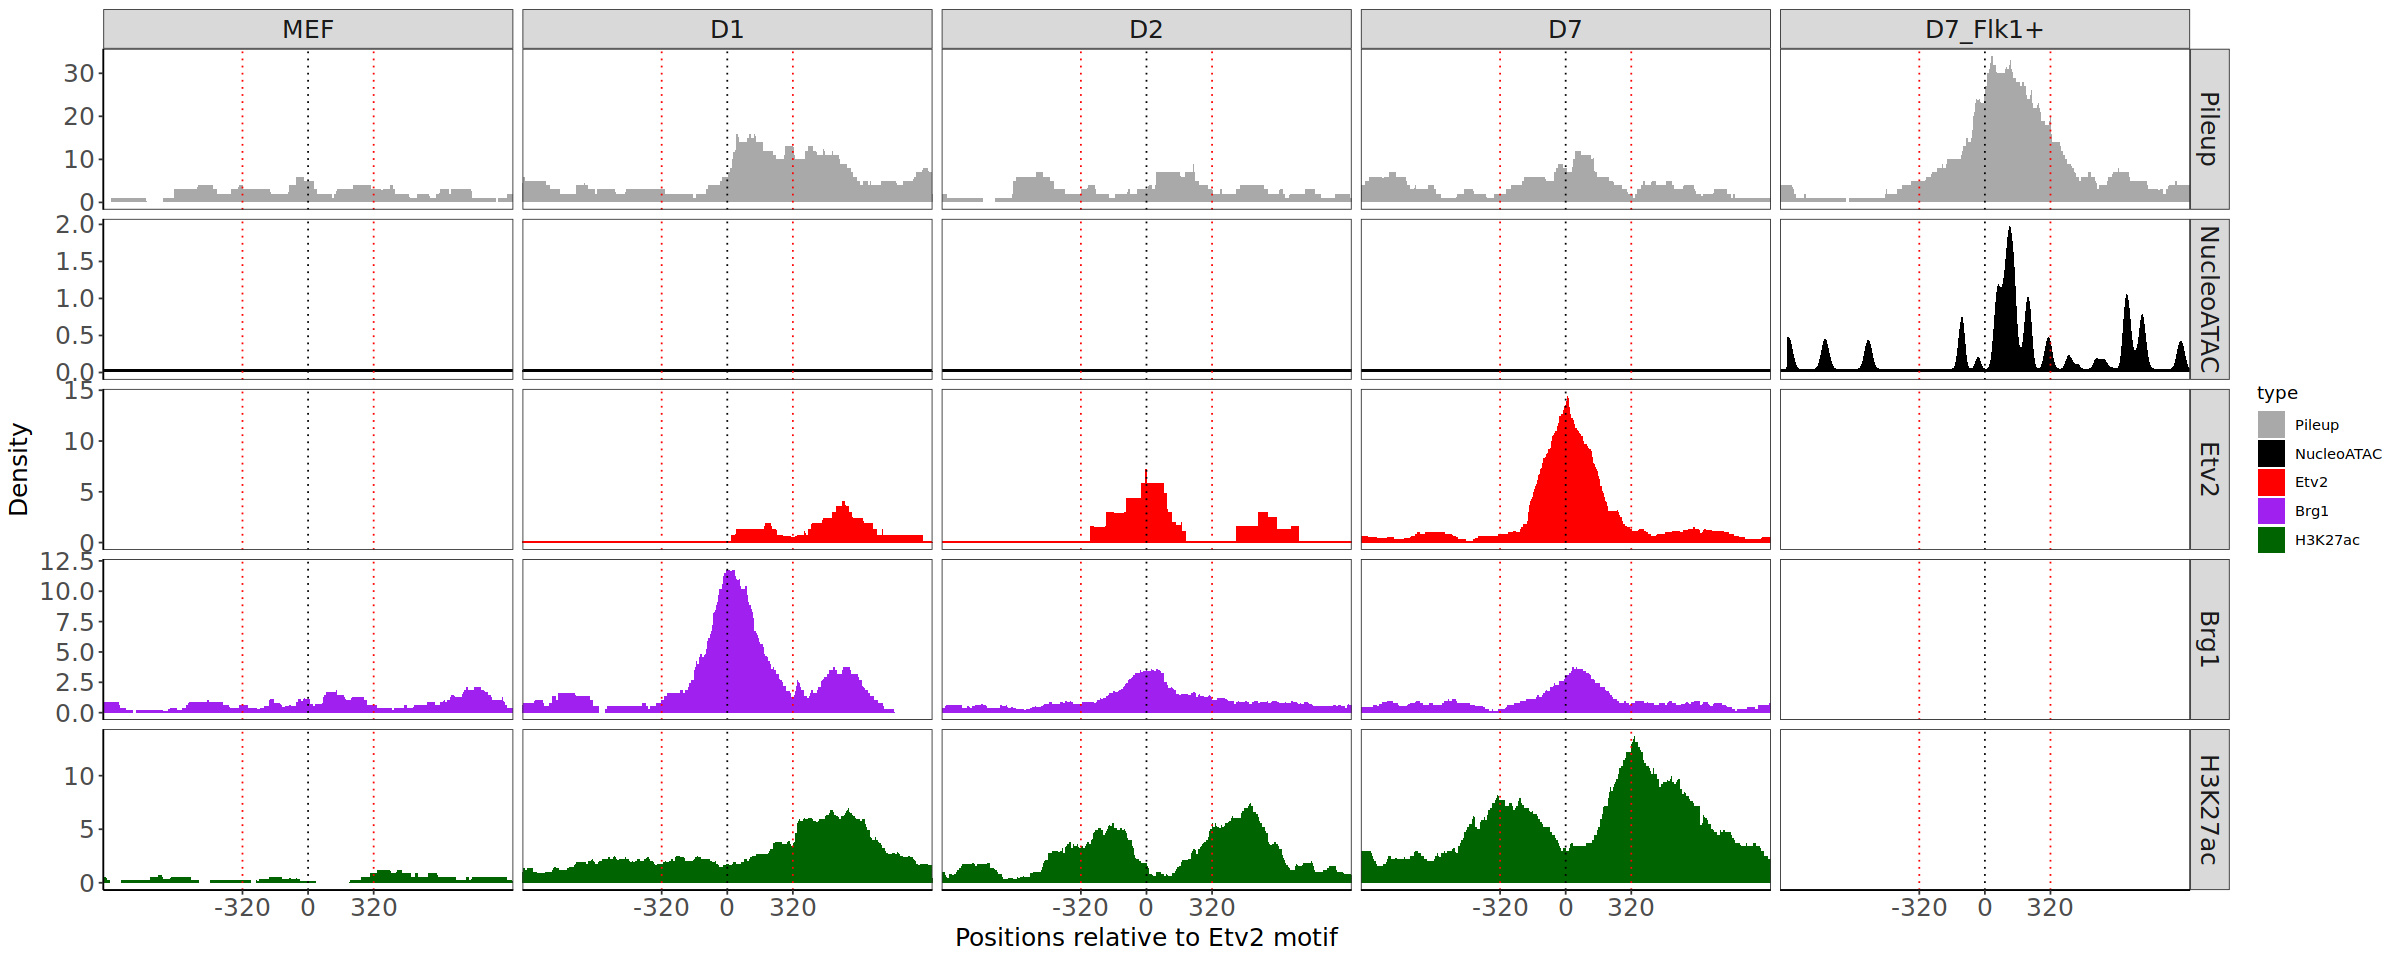

In [ ]:
options(repr.plot.width = 19.4, repr.plot.height = 4)
vplot(x2, 'counts', ncol = 5)
vplot(x2, 'predicted_counts', ncol = 5)
options(repr.plot.width = 20, repr.plot.height = 8)
plot_track(x2)

### chr12:104102210-104102849

In [ ]:
x2 <- x[seqnames(x) == 'chr12' & start(x) == 104102210]
sprintf('%s:%d-%d', seqnames(x2), start(x2), end(x2)) %>% message()

chr12:104102210-104102849



Warning message:
"Removed 320 rows containing missing values (`geom_raster()`)."
Warning message:
"Removed 320 rows containing missing values (`geom_raster()`)."


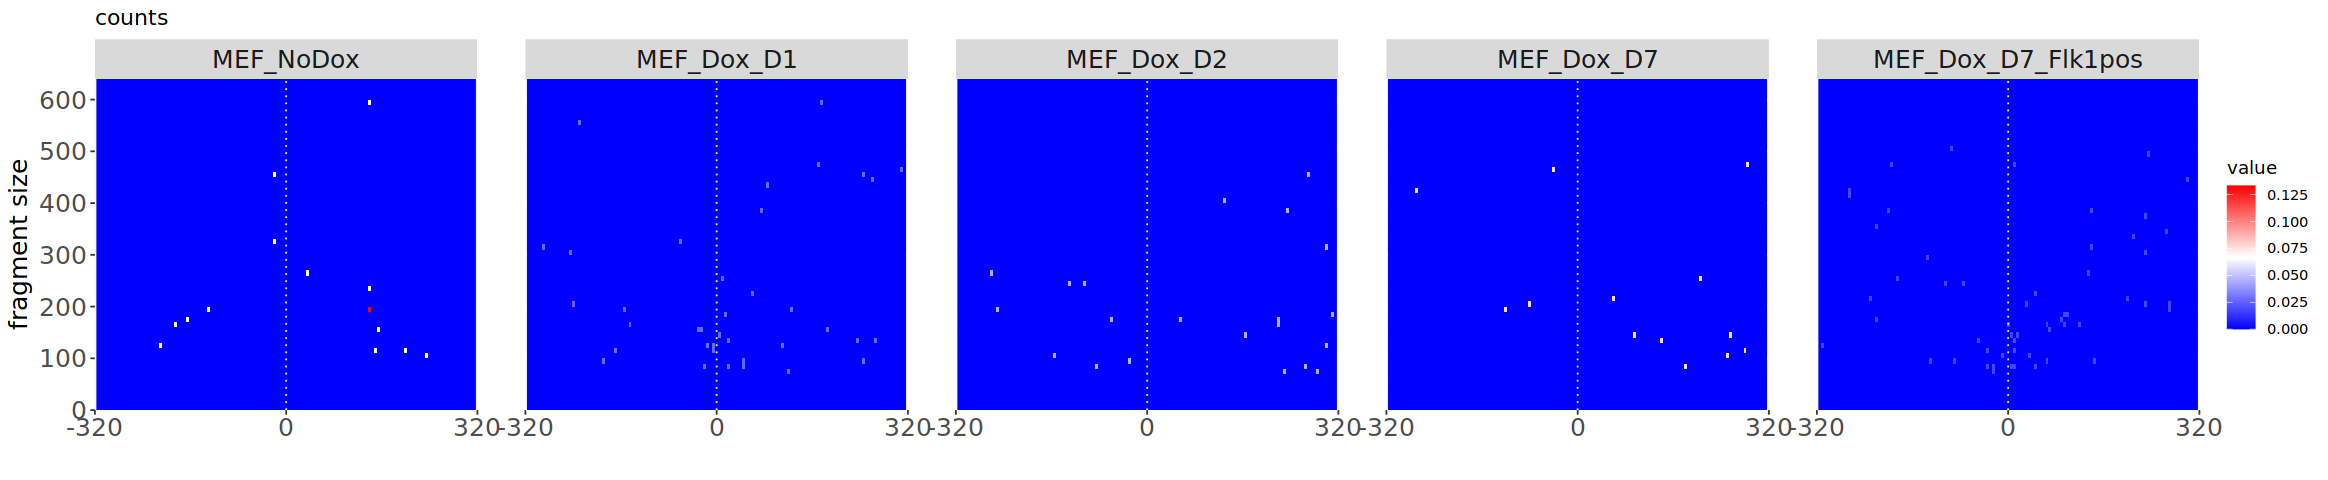

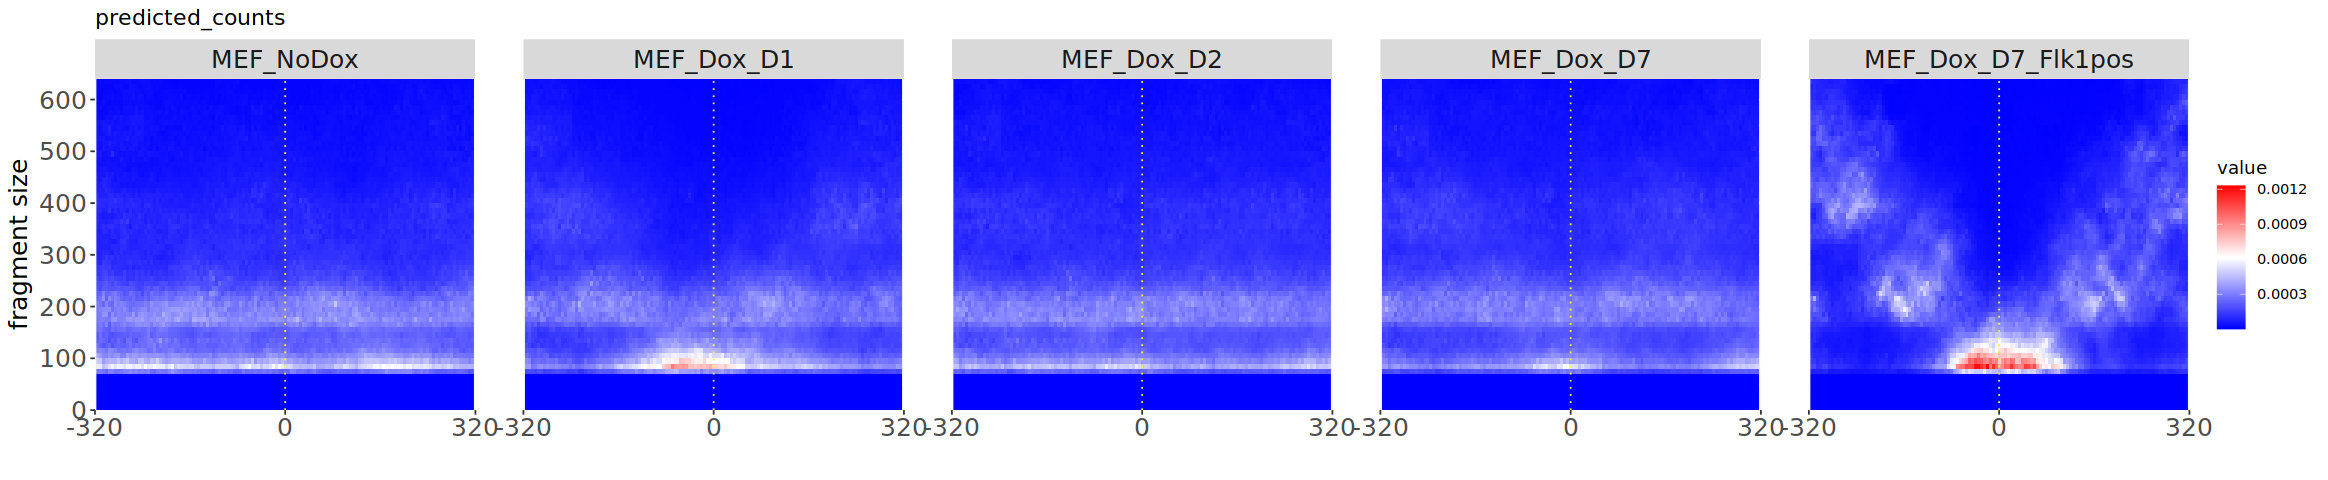

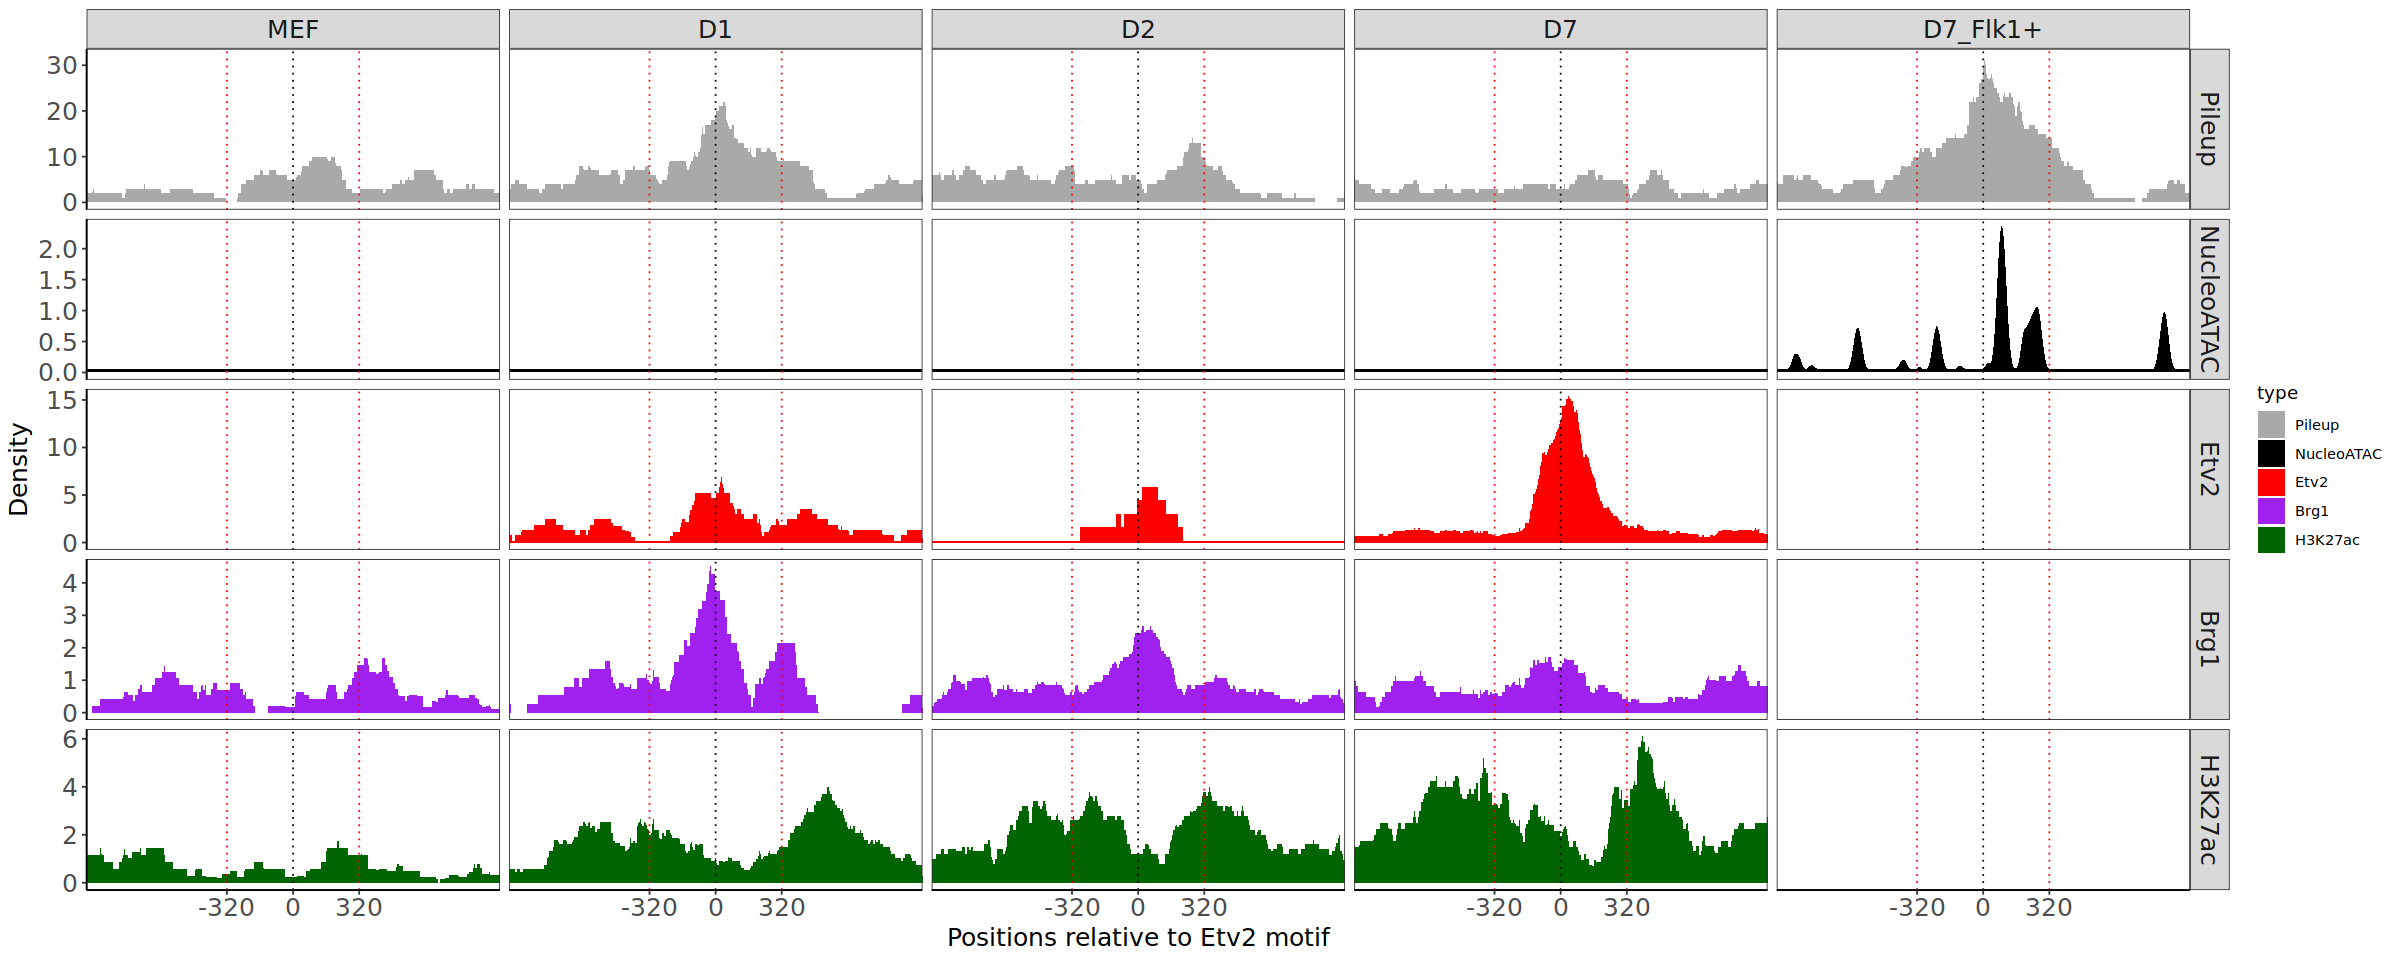

In [ ]:
options(repr.plot.width = 19.4, repr.plot.height = 4)
vplot(x2, 'counts', ncol = 5)
vplot(x2, 'predicted_counts', ncol = 5)
options(repr.plot.width = 20, repr.plot.height = 8)
plot_track(x2)

### chr1:149846590-149847229

In [ ]:
x2 <- x[seqnames(x) == 'chr1' & start(x) == 149846590]
sprintf('%s:%d-%d', seqnames(x2), start(x2), end(x2)) %>% message()

chr1:149846590-149847229



Warning message:
"Removed 320 rows containing missing values (`geom_raster()`)."
Warning message:
"Removed 320 rows containing missing values (`geom_raster()`)."


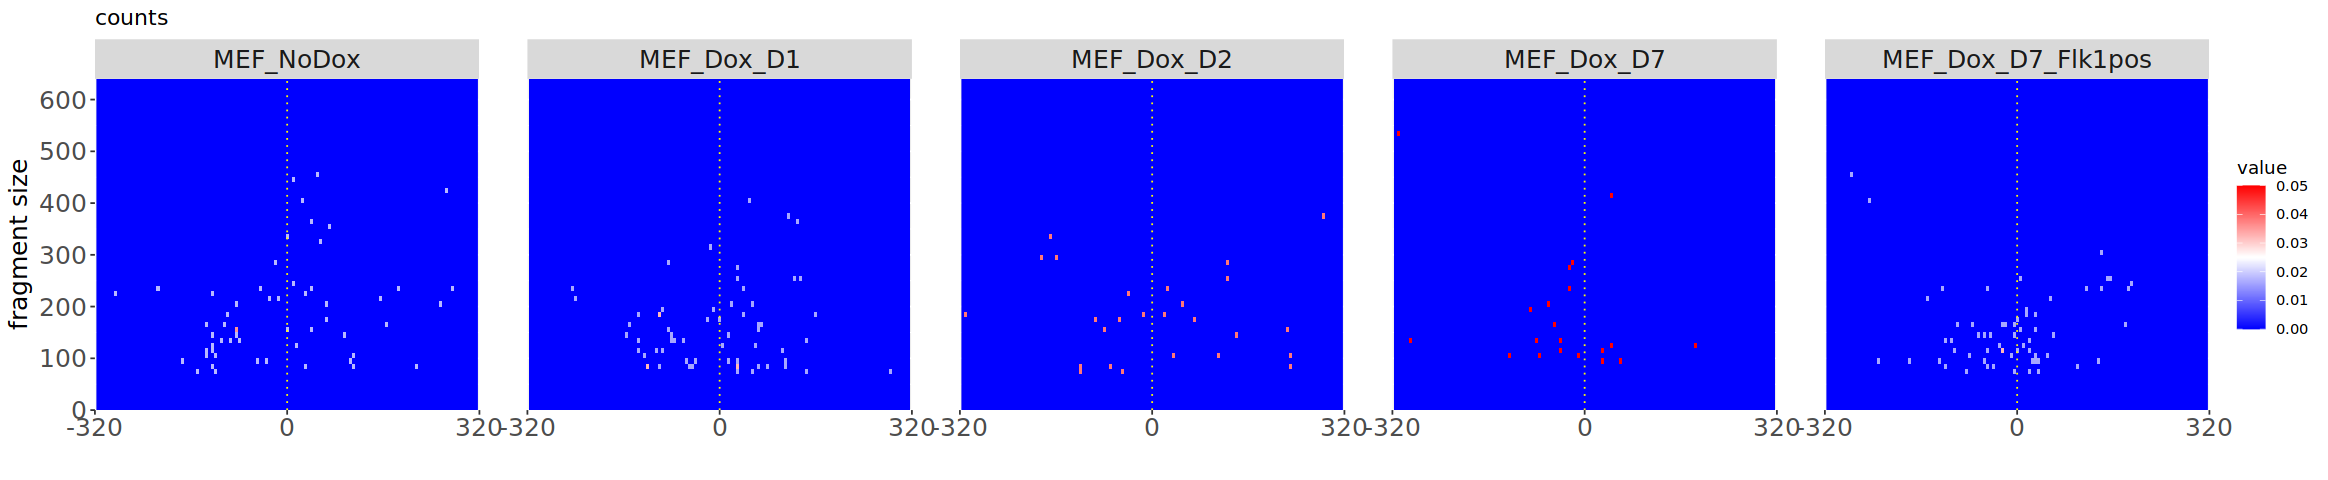

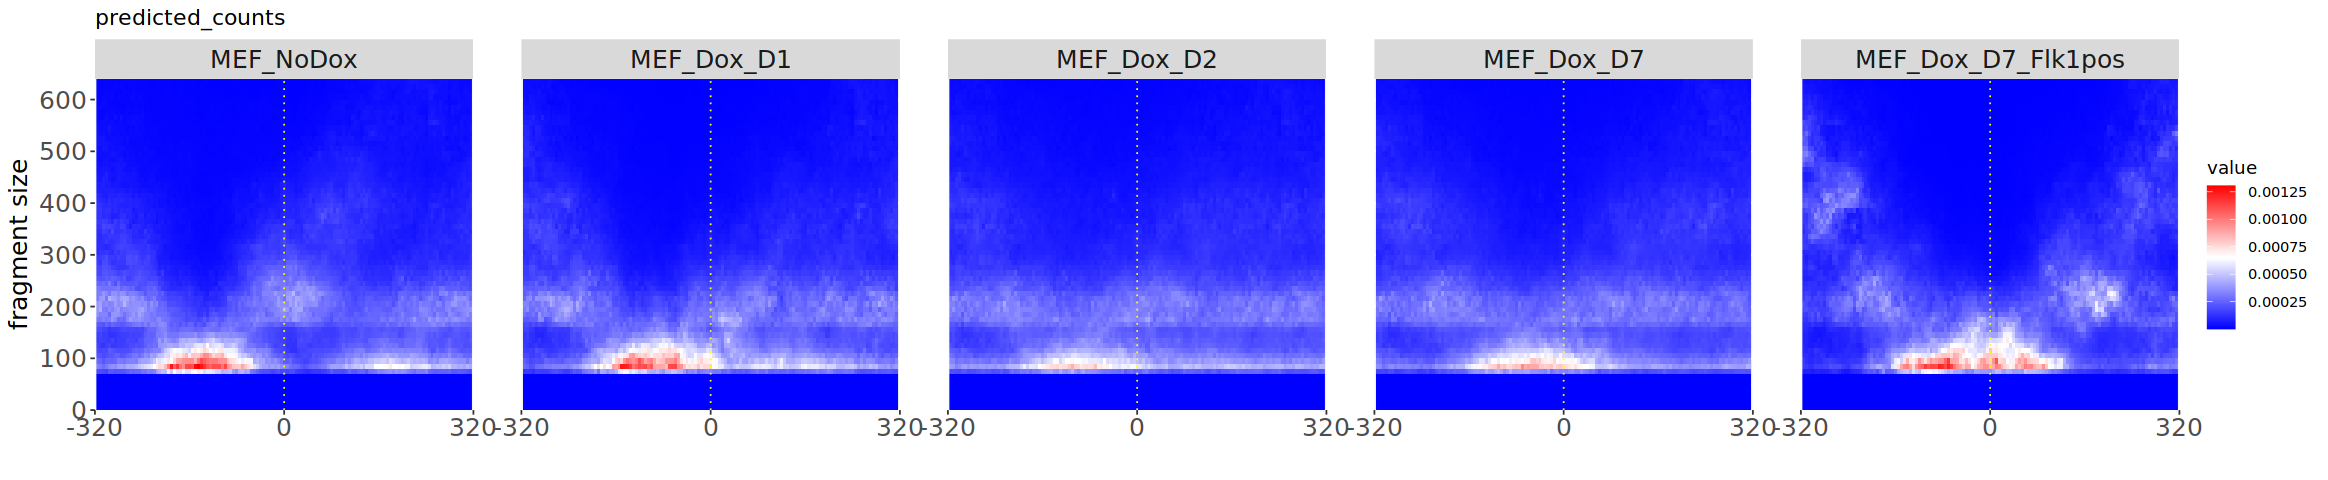

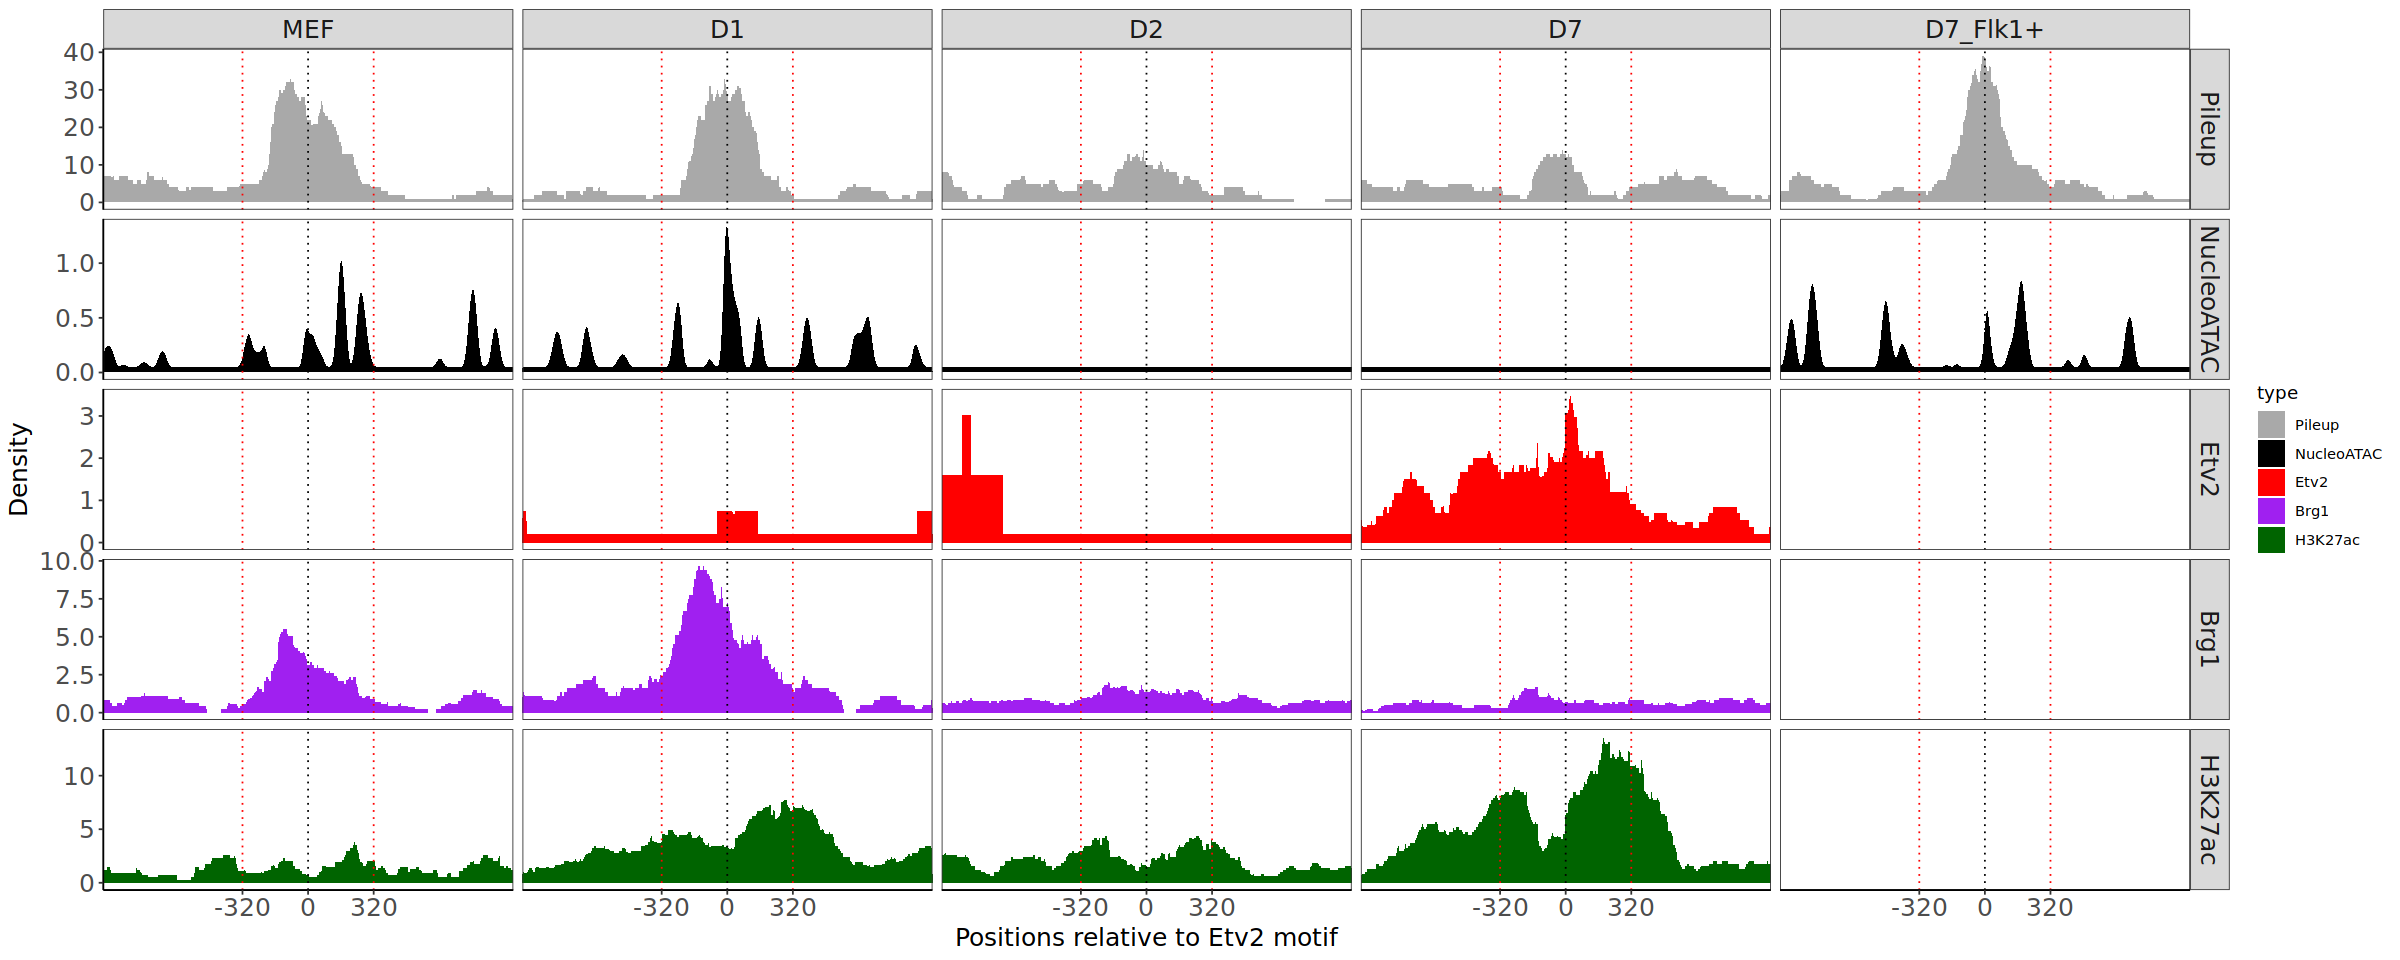

In [ ]:
options(repr.plot.width = 19.4, repr.plot.height = 4)
vplot(x2, 'counts', ncol = 5)
vplot(x2, 'predicted_counts', ncol = 5)
options(repr.plot.width = 20, repr.plot.height = 8)
plot_track(x2)

## Plot significant NFR->NOR regions

In [ ]:
res <- model %>% results(x, type = 'vplots', contrast = c('name', 'MEF_NoDox', 'MEF_Dox_D7_Flk1pos'))
res$index <- 1:length(res)
res <- res[res$padj < 0.05]
res <- res[order(res$log_ratio, decreasing = TRUE)]

### chr7:107720654-107721293

In [ ]:
x2 <- x[seqnames(x) == 'chr7' & start(x) == 107720654]
sprintf('%s:%d-%d', seqnames(x2), start(x2), end(x2)) %>% message()

chr7:107720654-107721293



Warning message:
"Removed 320 rows containing missing values (`geom_raster()`)."
Warning message:
"Removed 320 rows containing missing values (`geom_raster()`)."


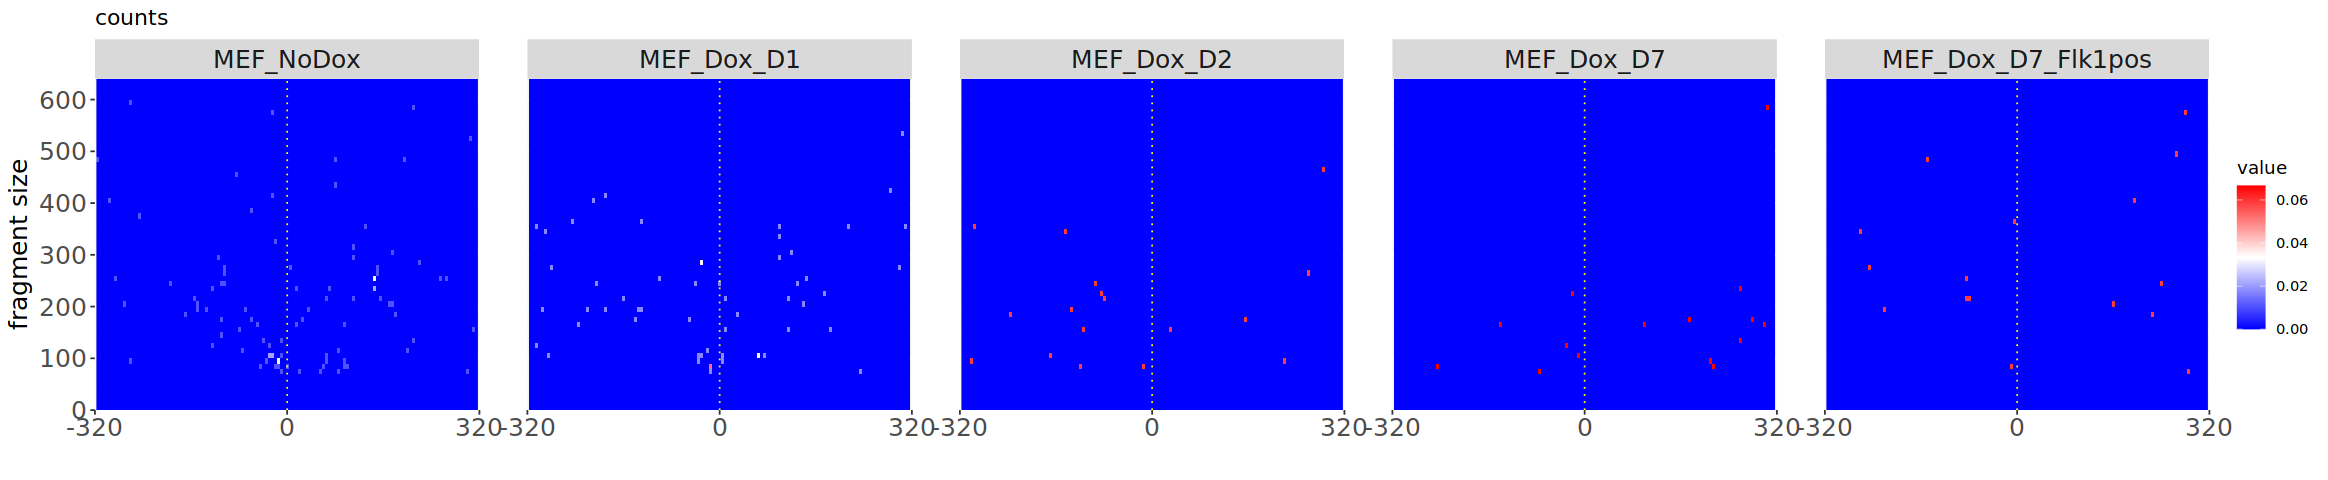

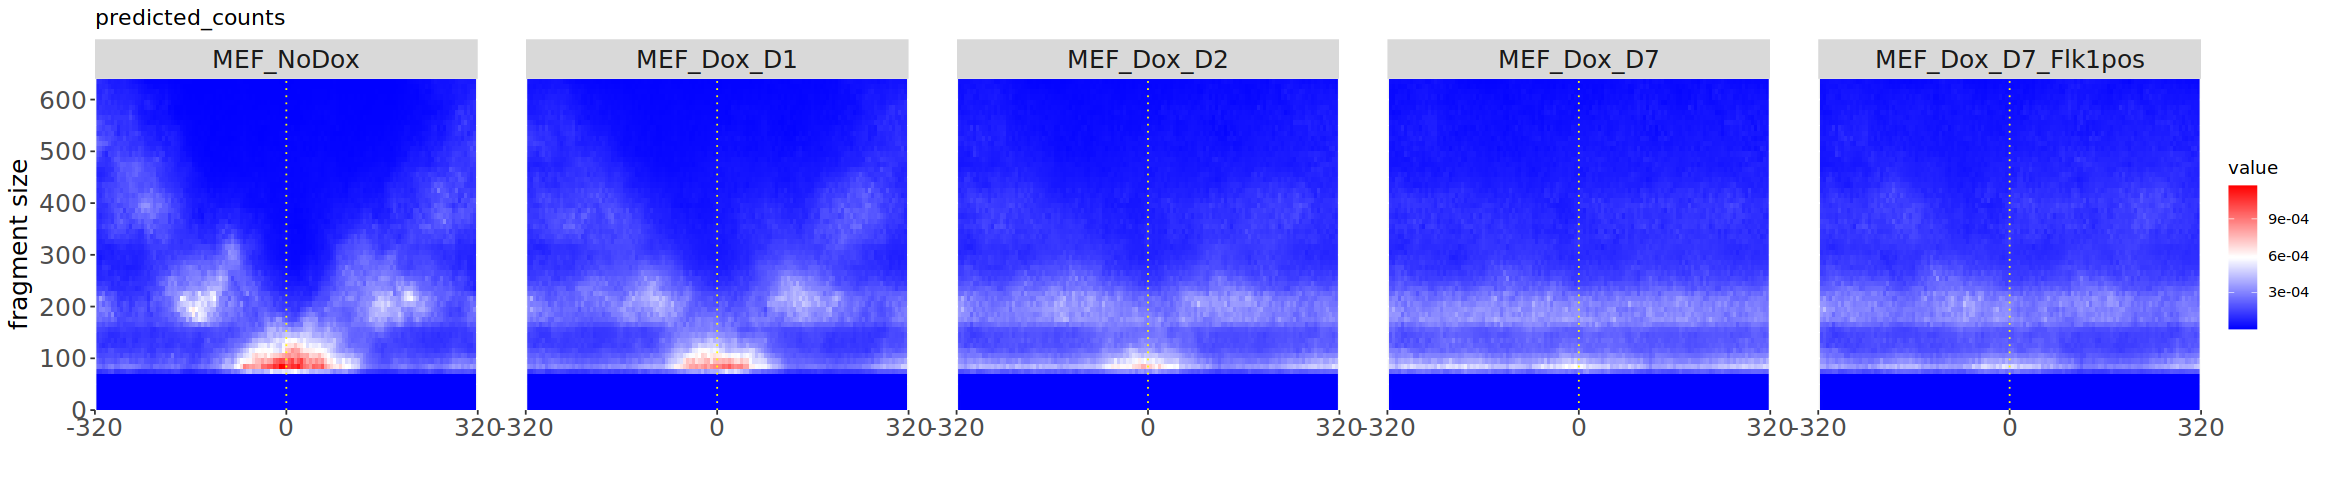

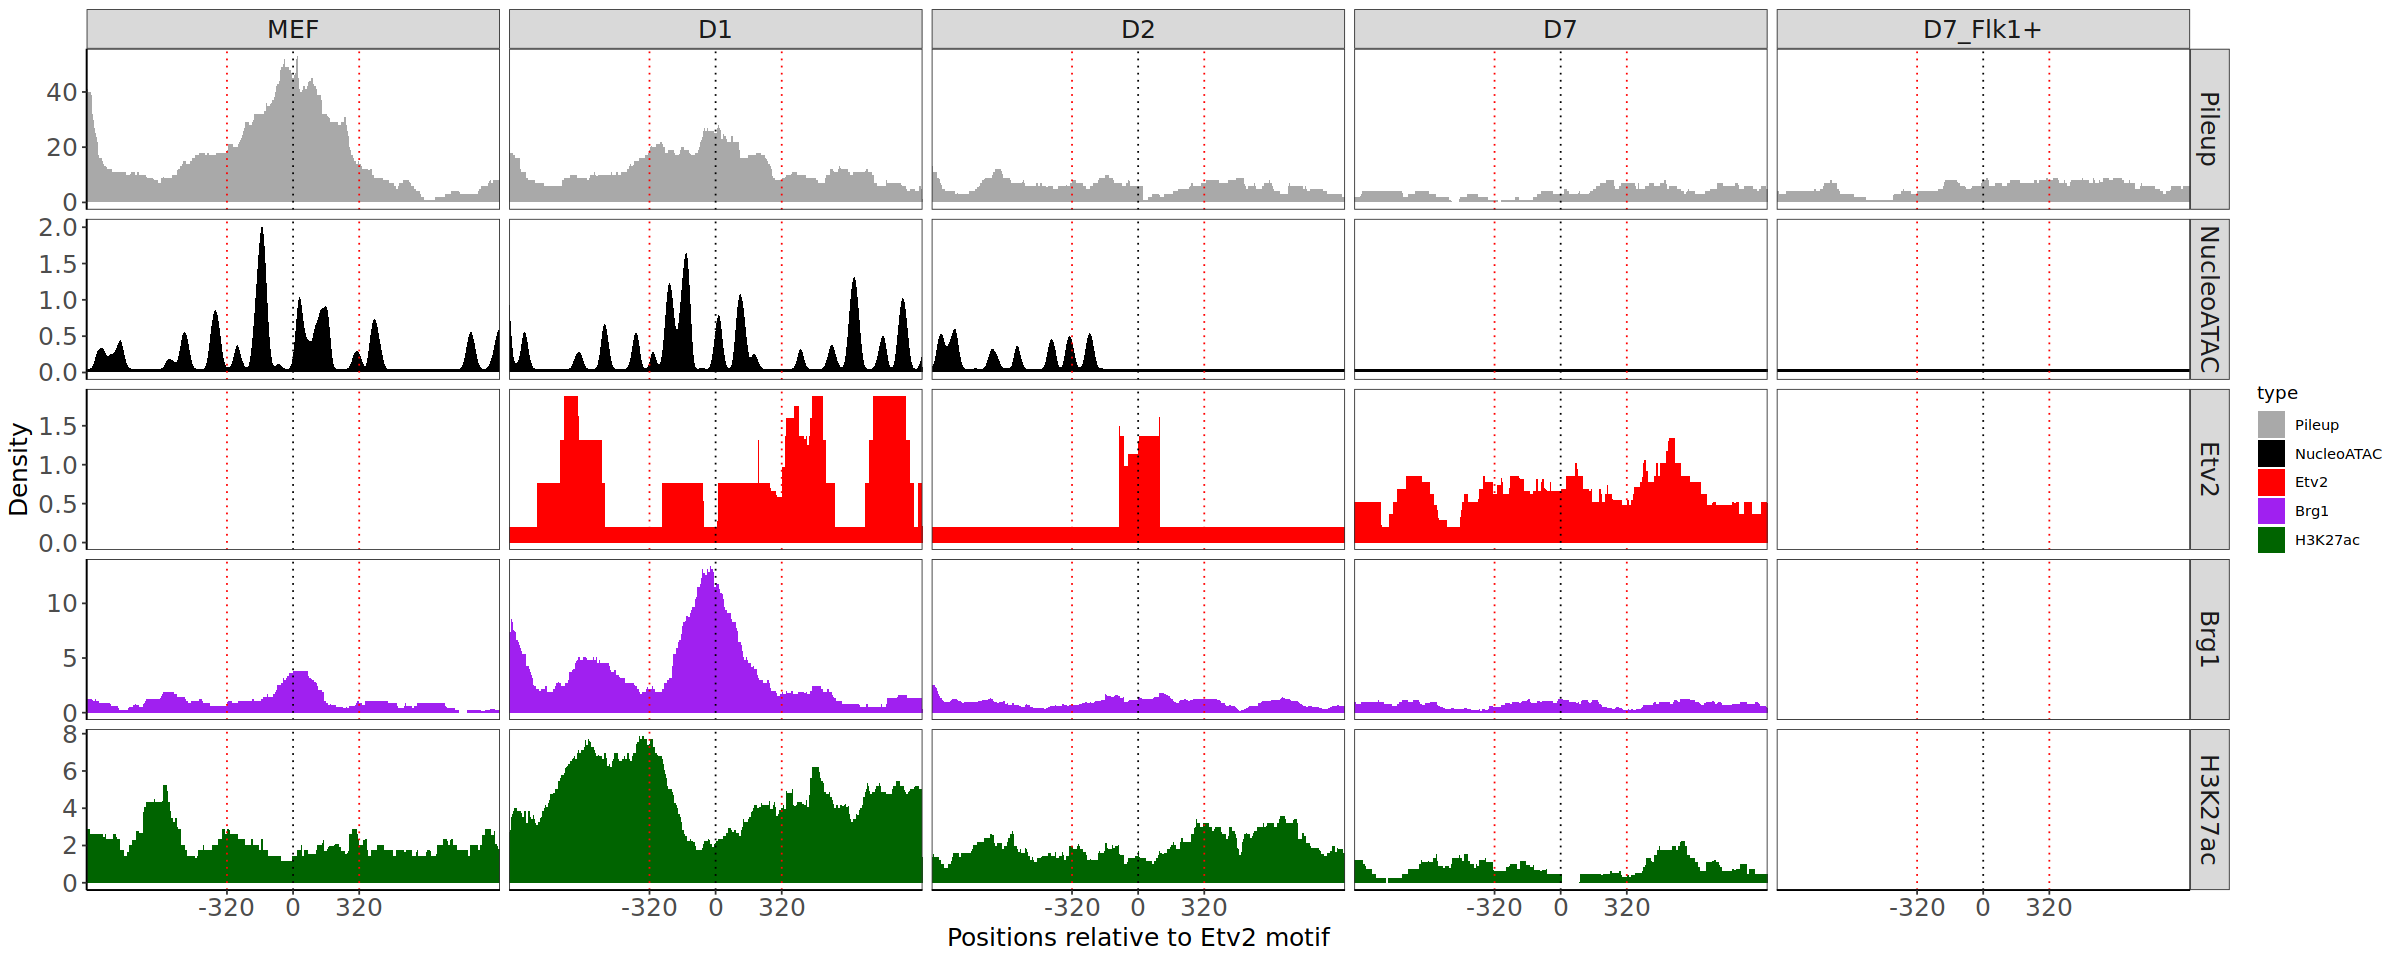

In [ ]:
options(repr.plot.width = 19.4, repr.plot.height = 4)
vplot(x2, 'counts', ncol = 5)
vplot(x2, 'predicted_counts', ncol = 5)
options(repr.plot.width = 20, repr.plot.height = 8)
plot_track(x2)

### chr7:24365537-24366176

In [ ]:
x2 <- x[seqnames(x) == 'chr7' & start(x) == 24365537]
sprintf('%s:%d-%d', seqnames(x2), start(x2), end(x2)) %>% message()

chr7:24365537-24366176



Warning message:
"Removed 320 rows containing missing values (`geom_raster()`)."
Warning message:
"Removed 320 rows containing missing values (`geom_raster()`)."


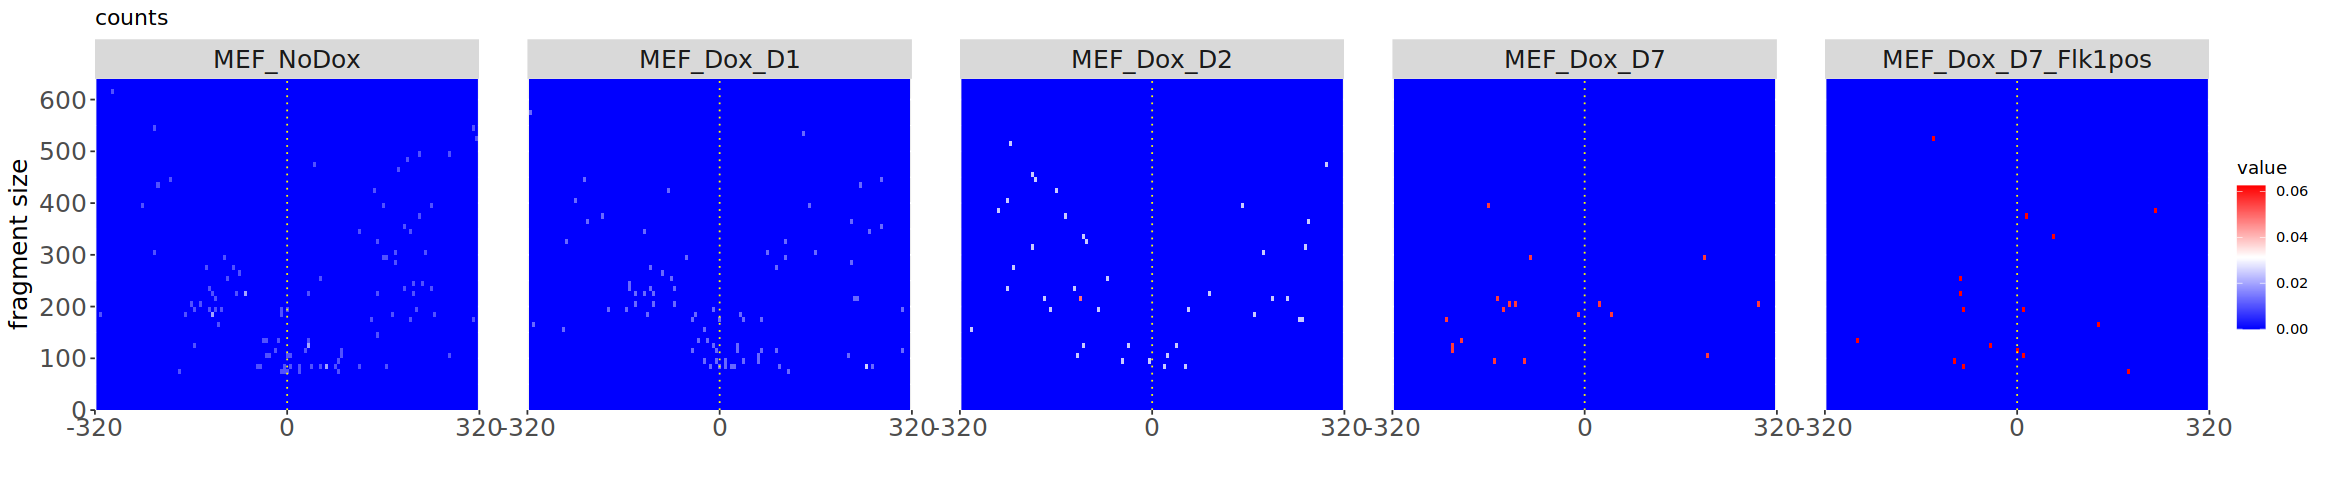

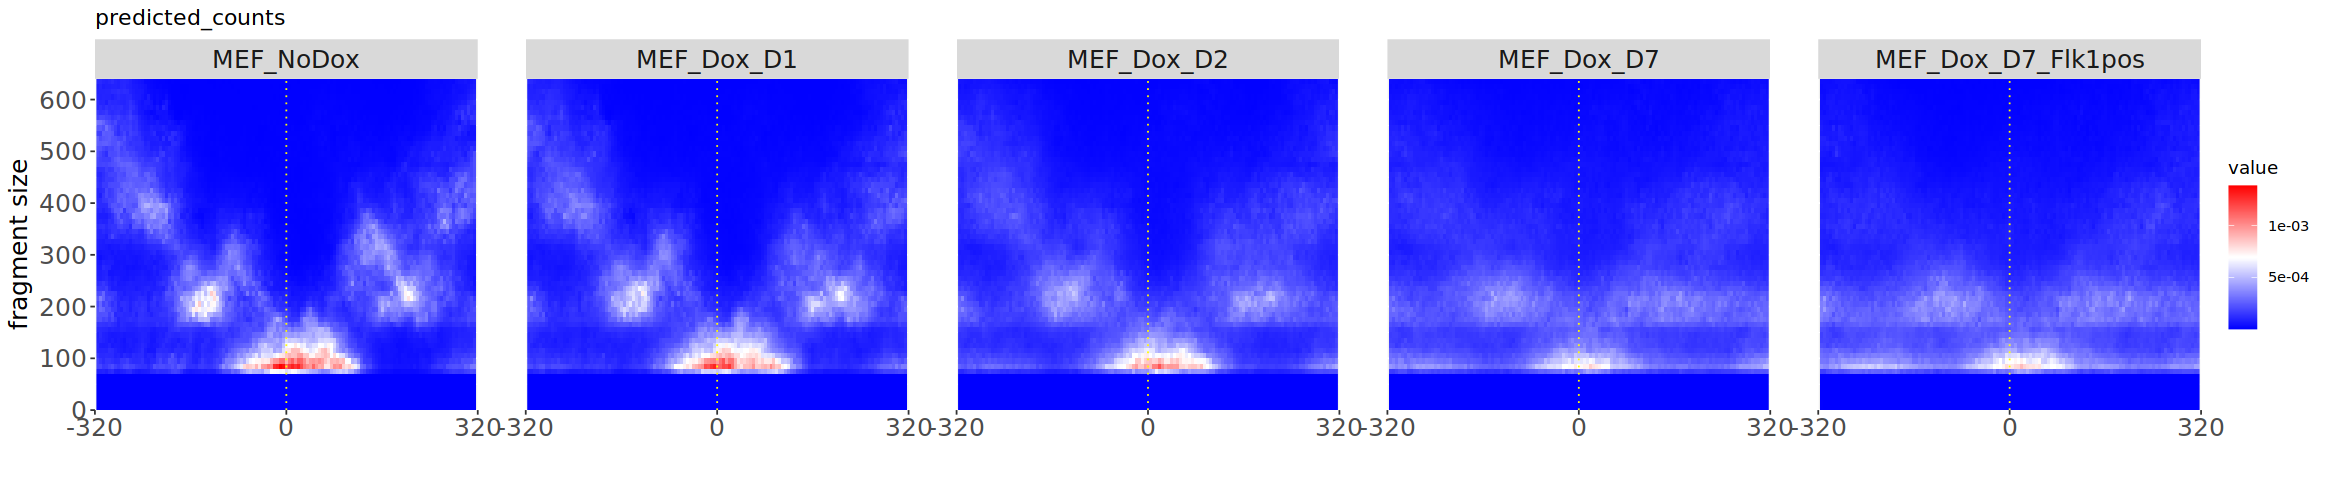

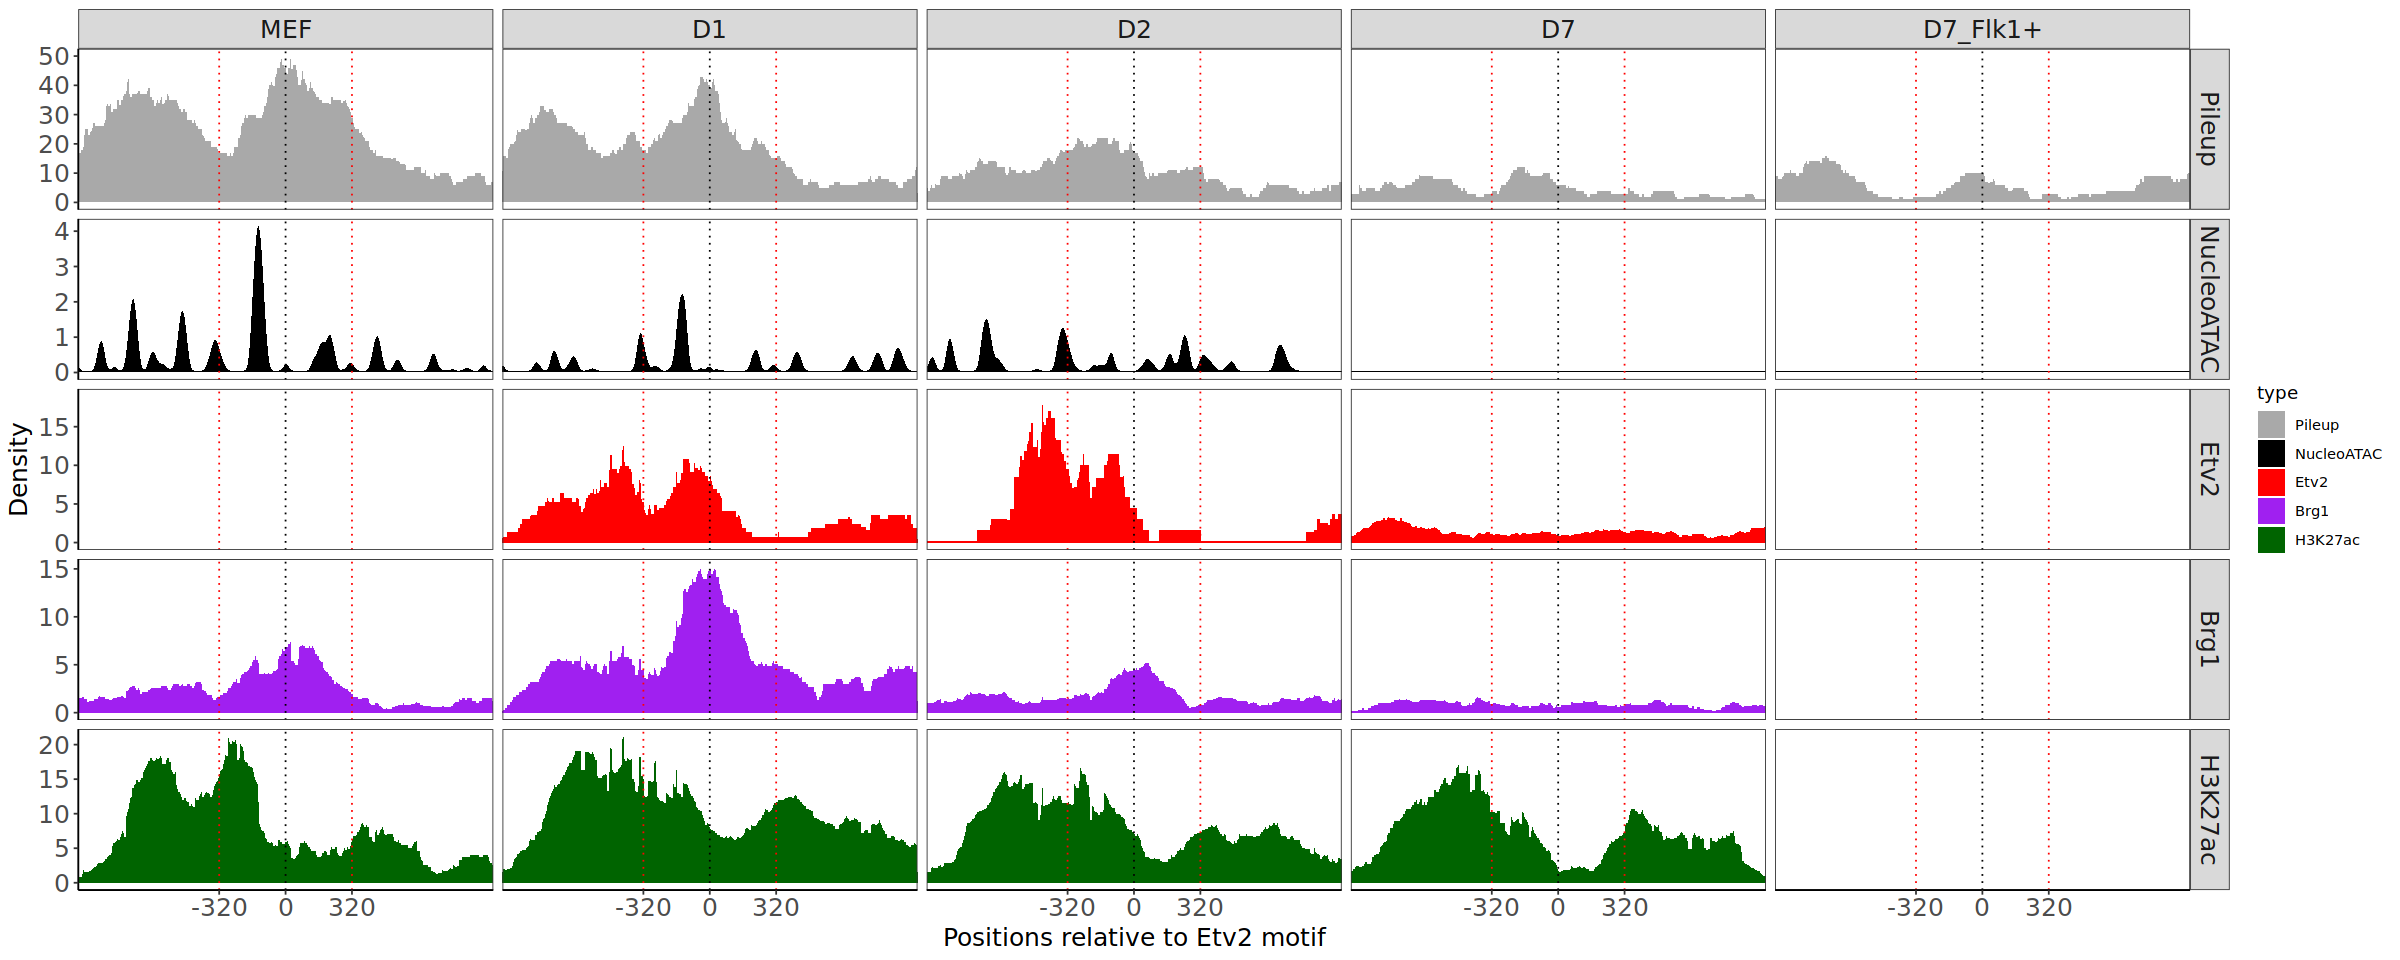

In [ ]:
options(repr.plot.width = 19.4, repr.plot.height = 4)
vplot(x2, 'counts', ncol = 5)
vplot(x2, 'predicted_counts', ncol = 5)
options(repr.plot.width = 20, repr.plot.height = 8)
plot_track(x2)

### chr11:52656002-52656641

In [ ]:
x2 <- x[seqnames(x) == 'chr11' & start(x) == 52656002]
sprintf('%s:%d-%d', seqnames(x2), start(x2), end(x2)) %>% message()

chr11:52656002-52656641



Warning message:
"Removed 320 rows containing missing values (`geom_raster()`)."
Warning message:
"Removed 320 rows containing missing values (`geom_raster()`)."


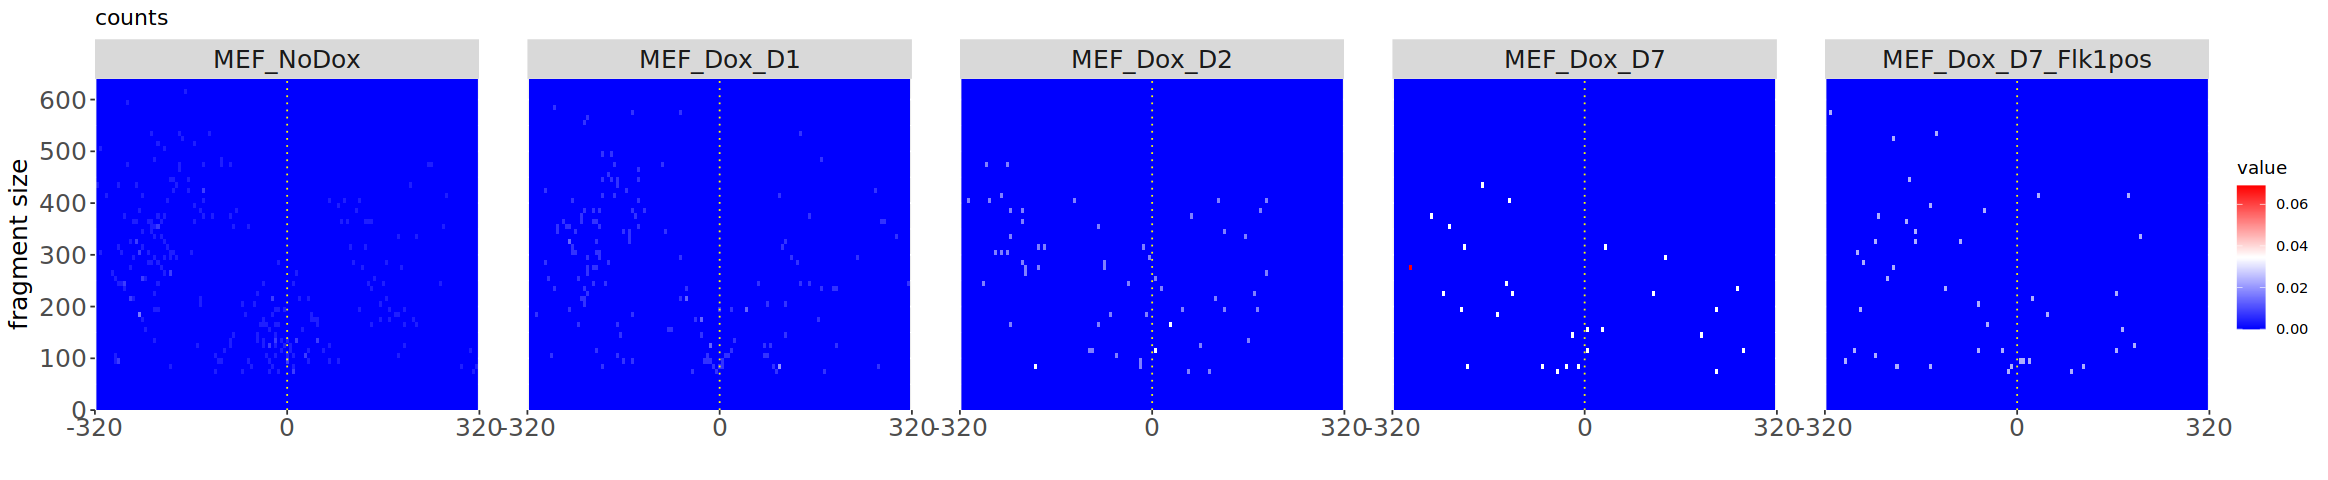

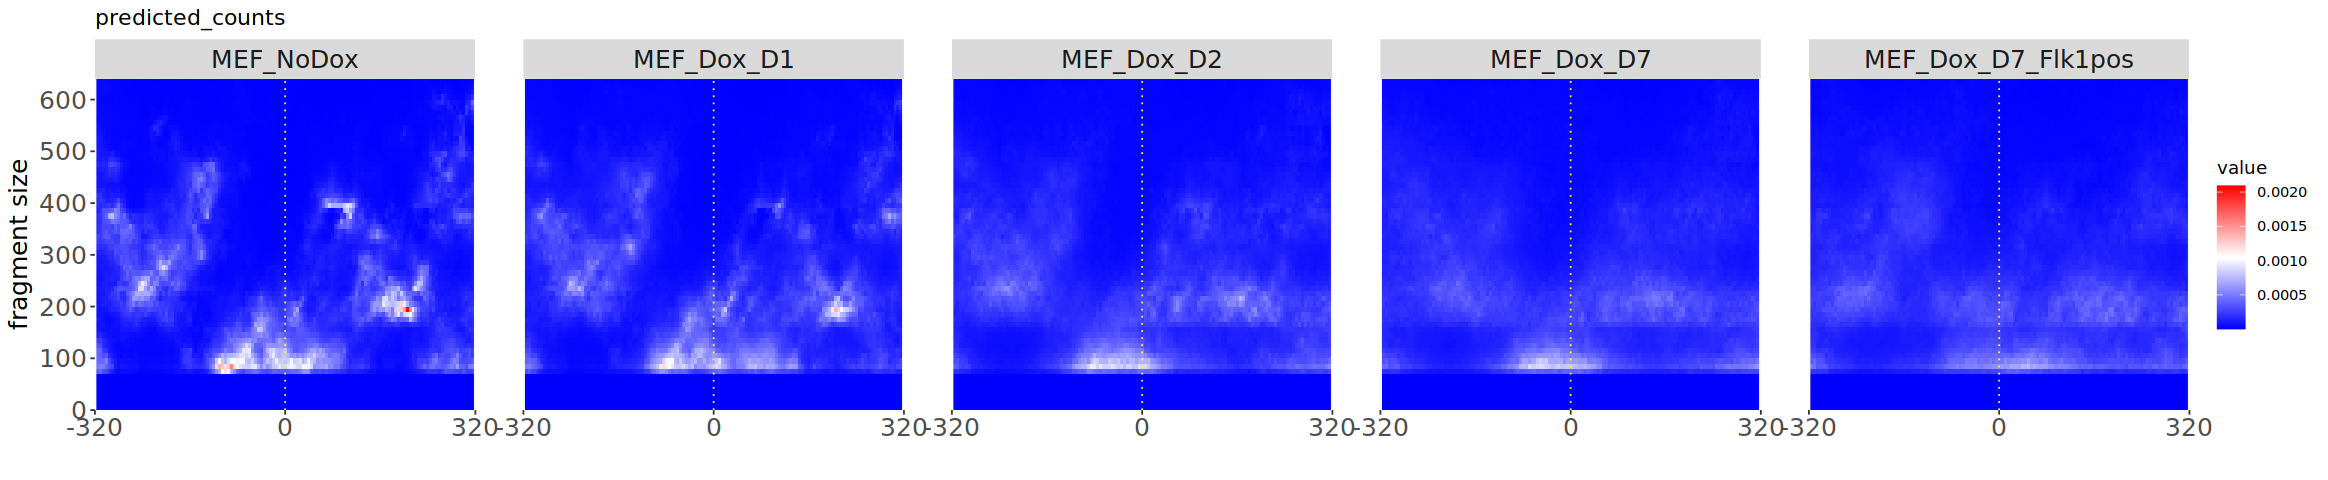

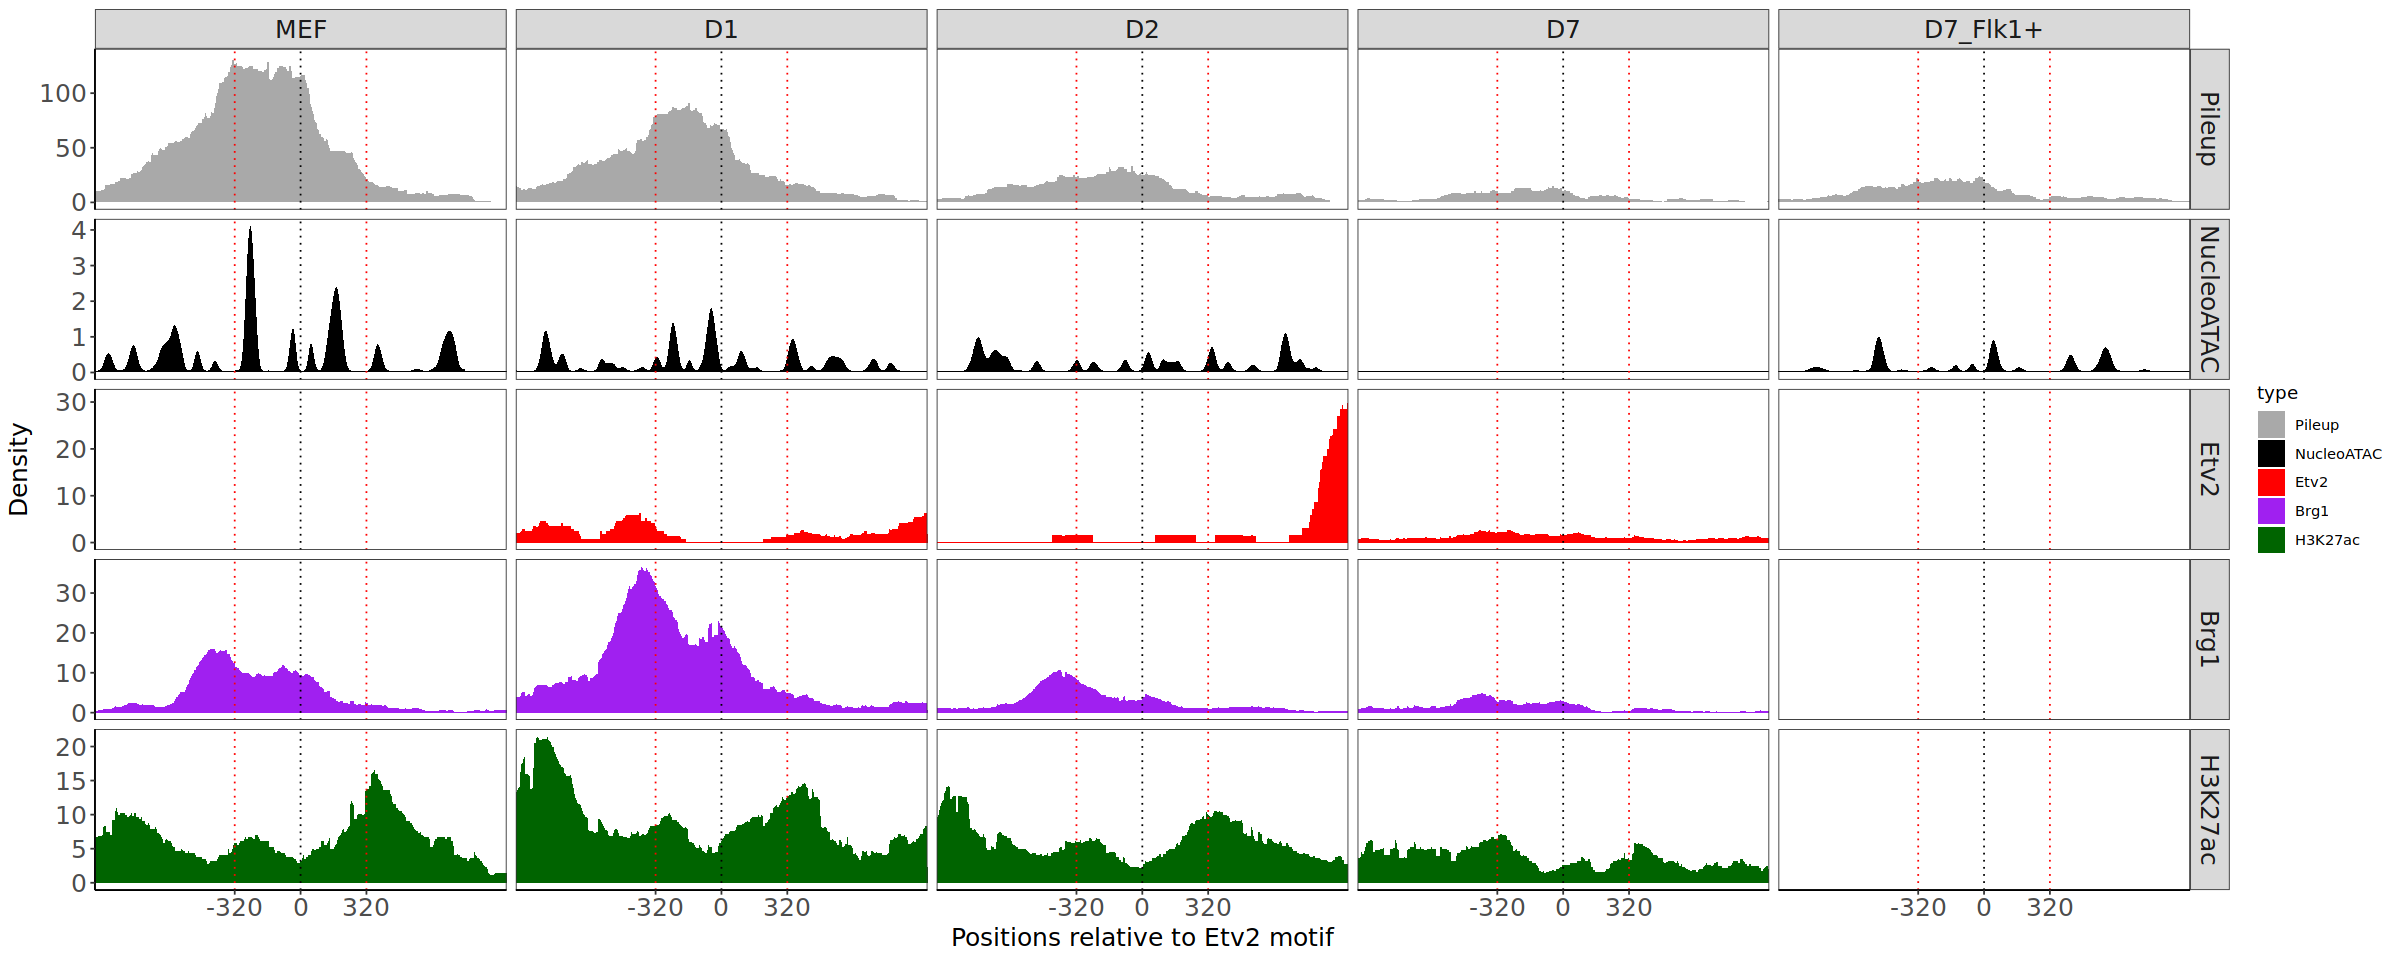

In [ ]:
options(repr.plot.width = 19.4, repr.plot.height = 4)
vplot(x2, 'counts', ncol = 5)
vplot(x2, 'predicted_counts', ncol = 5)
options(repr.plot.width = 20, repr.plot.height = 8)
plot_track(x2)

### chr1:31050191-31050830


In [ ]:
x2 <- x[seqnames(x) == 'chr1' & start(x) == 31050191]
sprintf('%s:%d-%d', seqnames(x2), start(x2), end(x2)) %>% message()

chr1:31050191-31050830



Warning message:
"Removed 320 rows containing missing values (`geom_raster()`)."
Warning message:
"Removed 320 rows containing missing values (`geom_raster()`)."


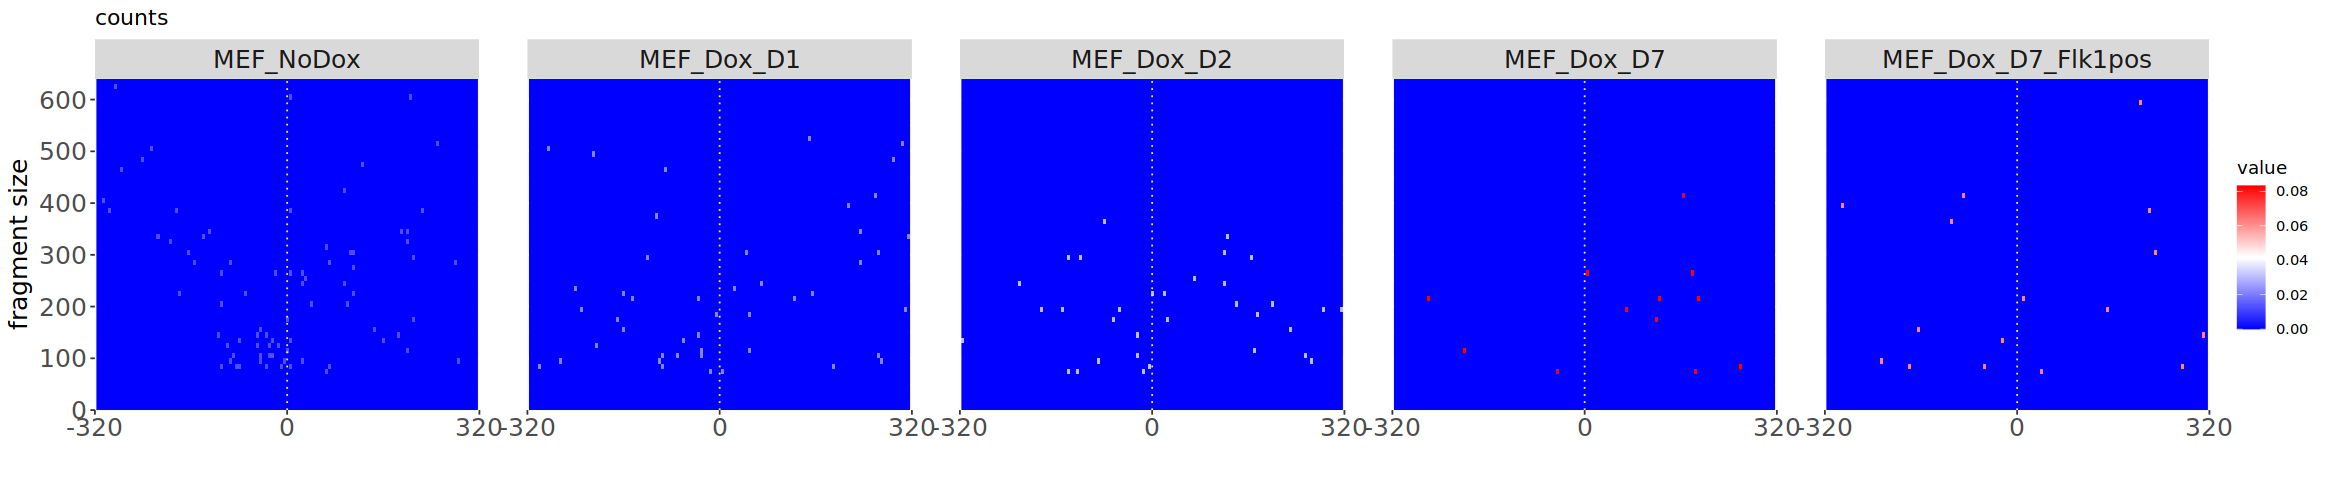

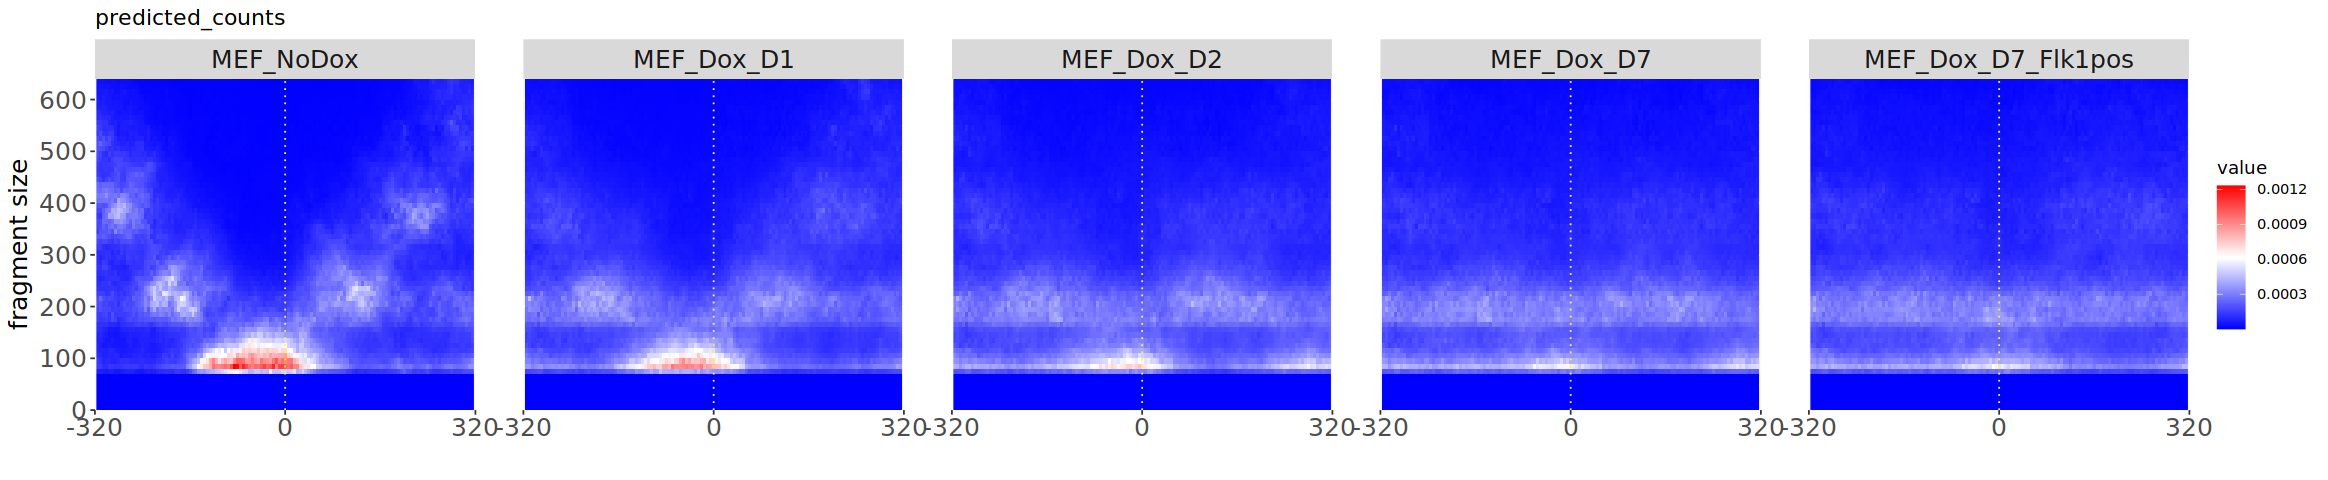

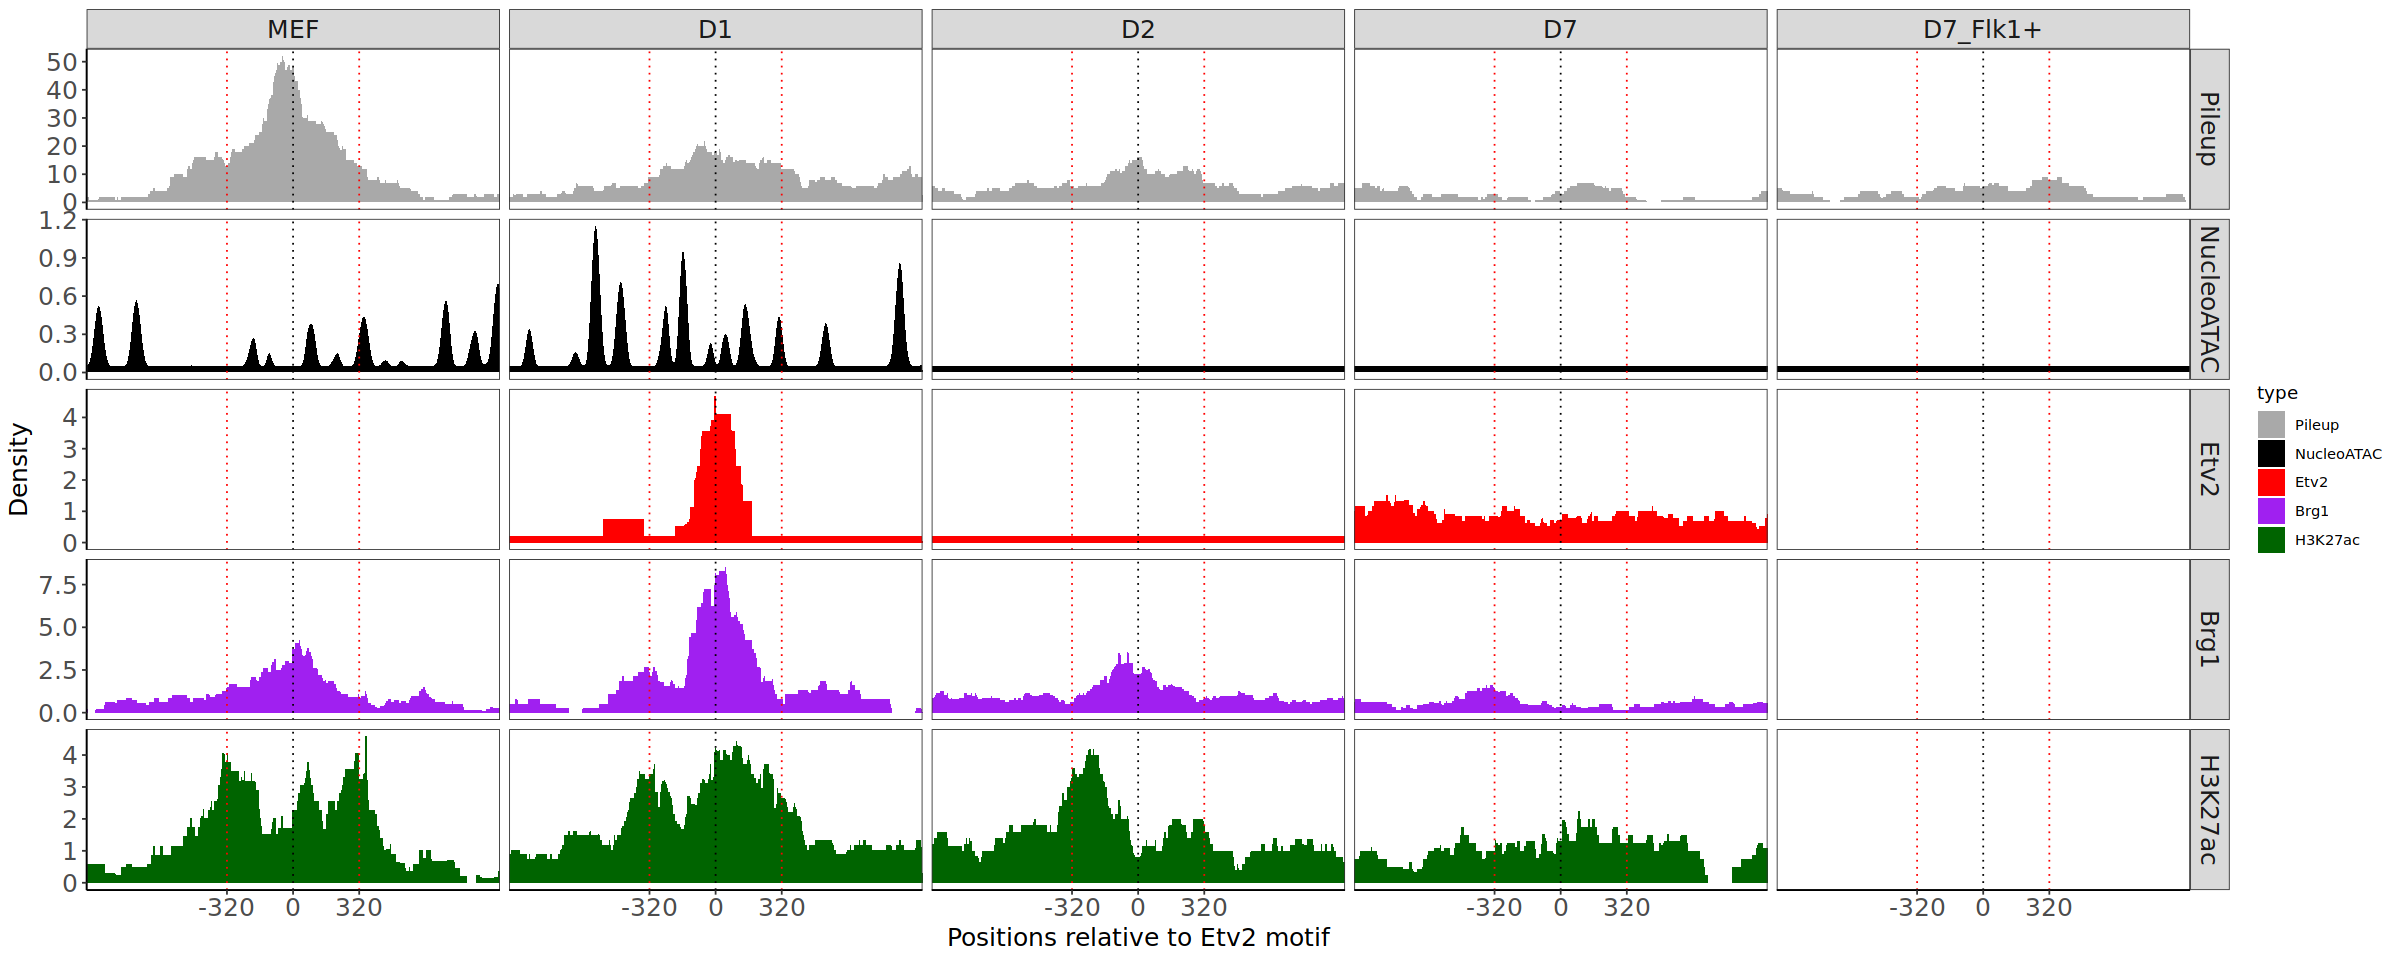

In [ ]:
options(repr.plot.width = 19.4, repr.plot.height = 4)
vplot(x2, 'counts', ncol = 5)
vplot(x2, 'predicted_counts', ncol = 5)
options(repr.plot.width = 20, repr.plot.height = 8)
plot_track(x2)

### chr8:88091529-88092168


In [ ]:
x2 <- x[seqnames(x) == 'chr8' & start(x) == 88091529]
sprintf('%s:%d-%d', seqnames(x2), start(x2), end(x2)) %>% message()

chr8:88091529-88092168



Warning message:
"Removed 320 rows containing missing values (`geom_raster()`)."
Warning message:
"Removed 320 rows containing missing values (`geom_raster()`)."


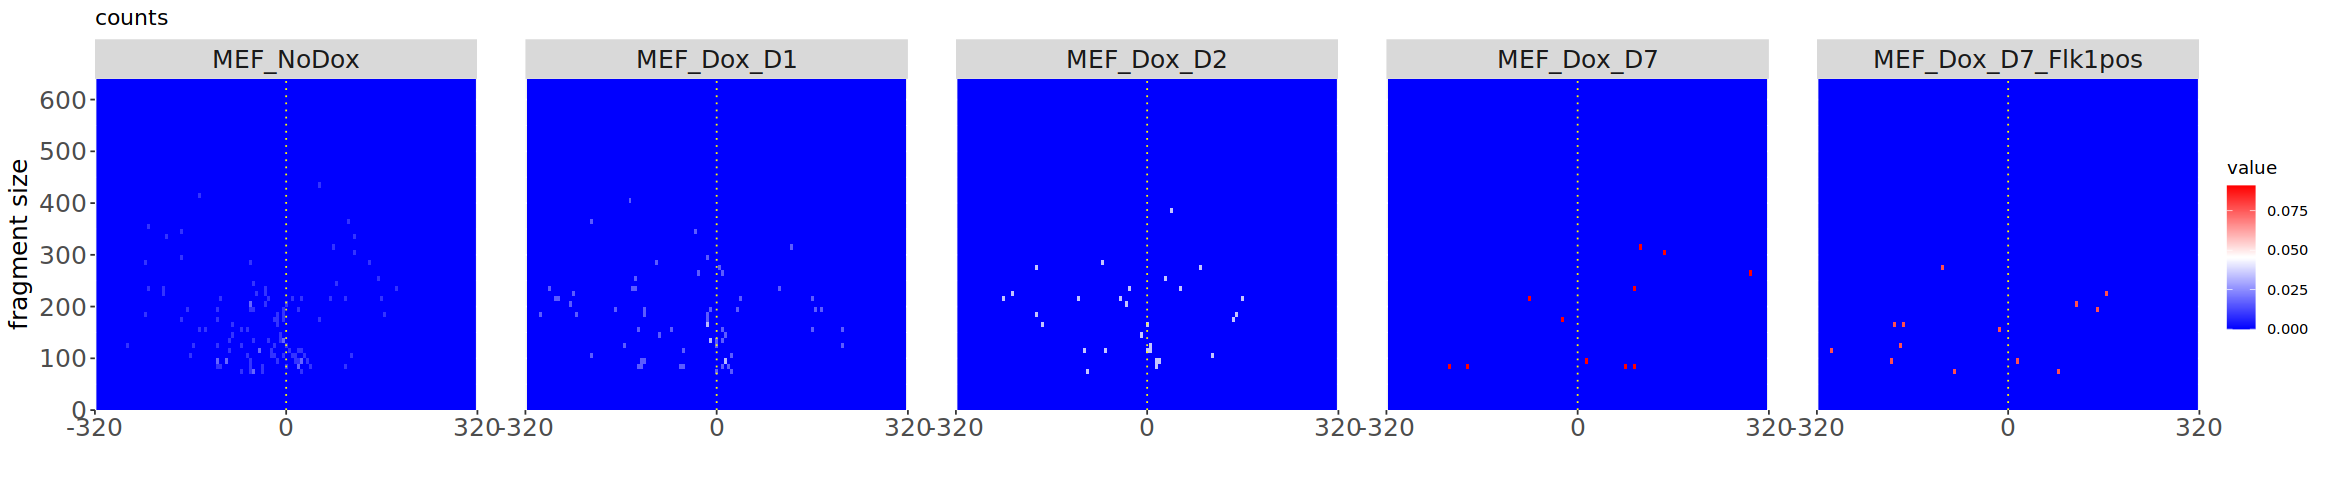

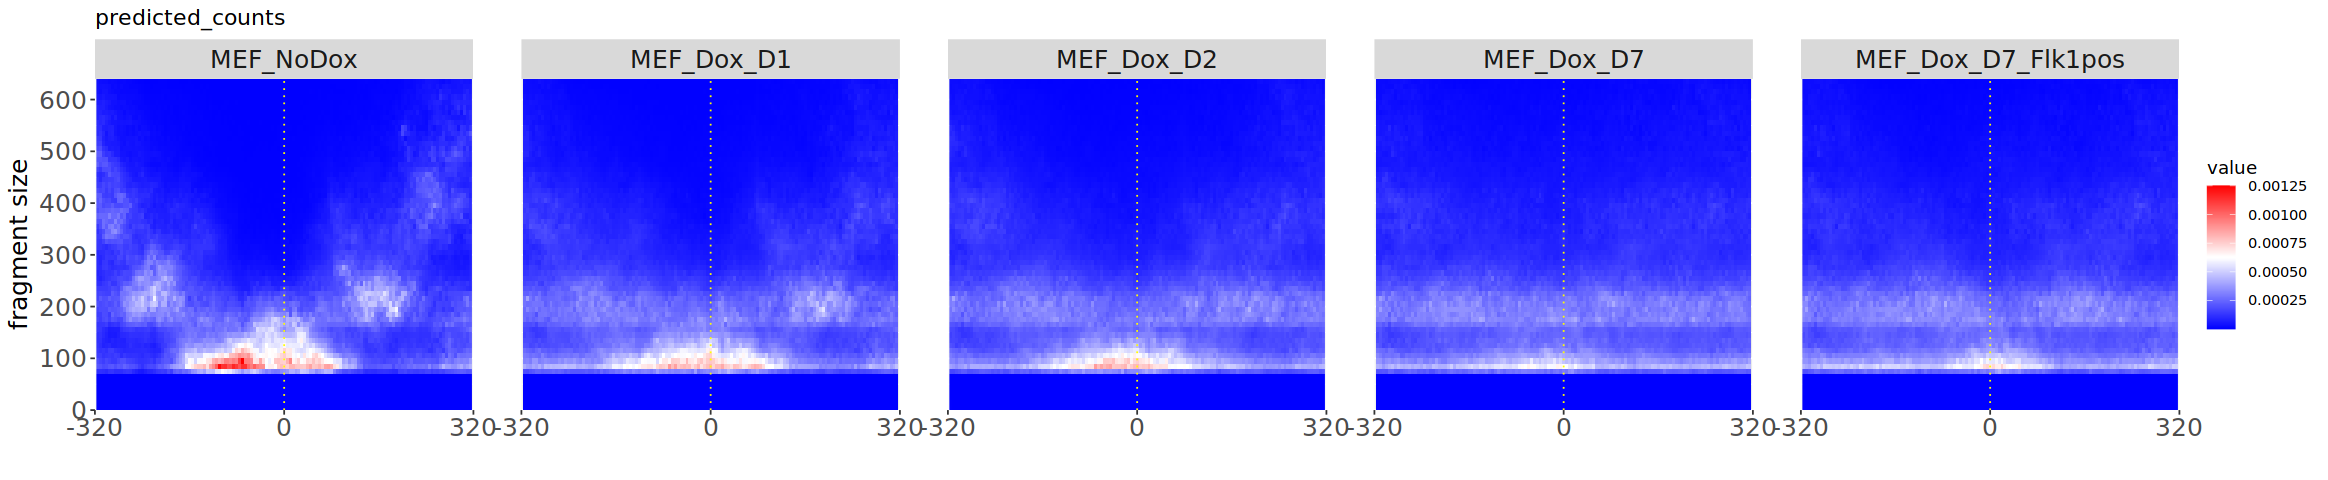

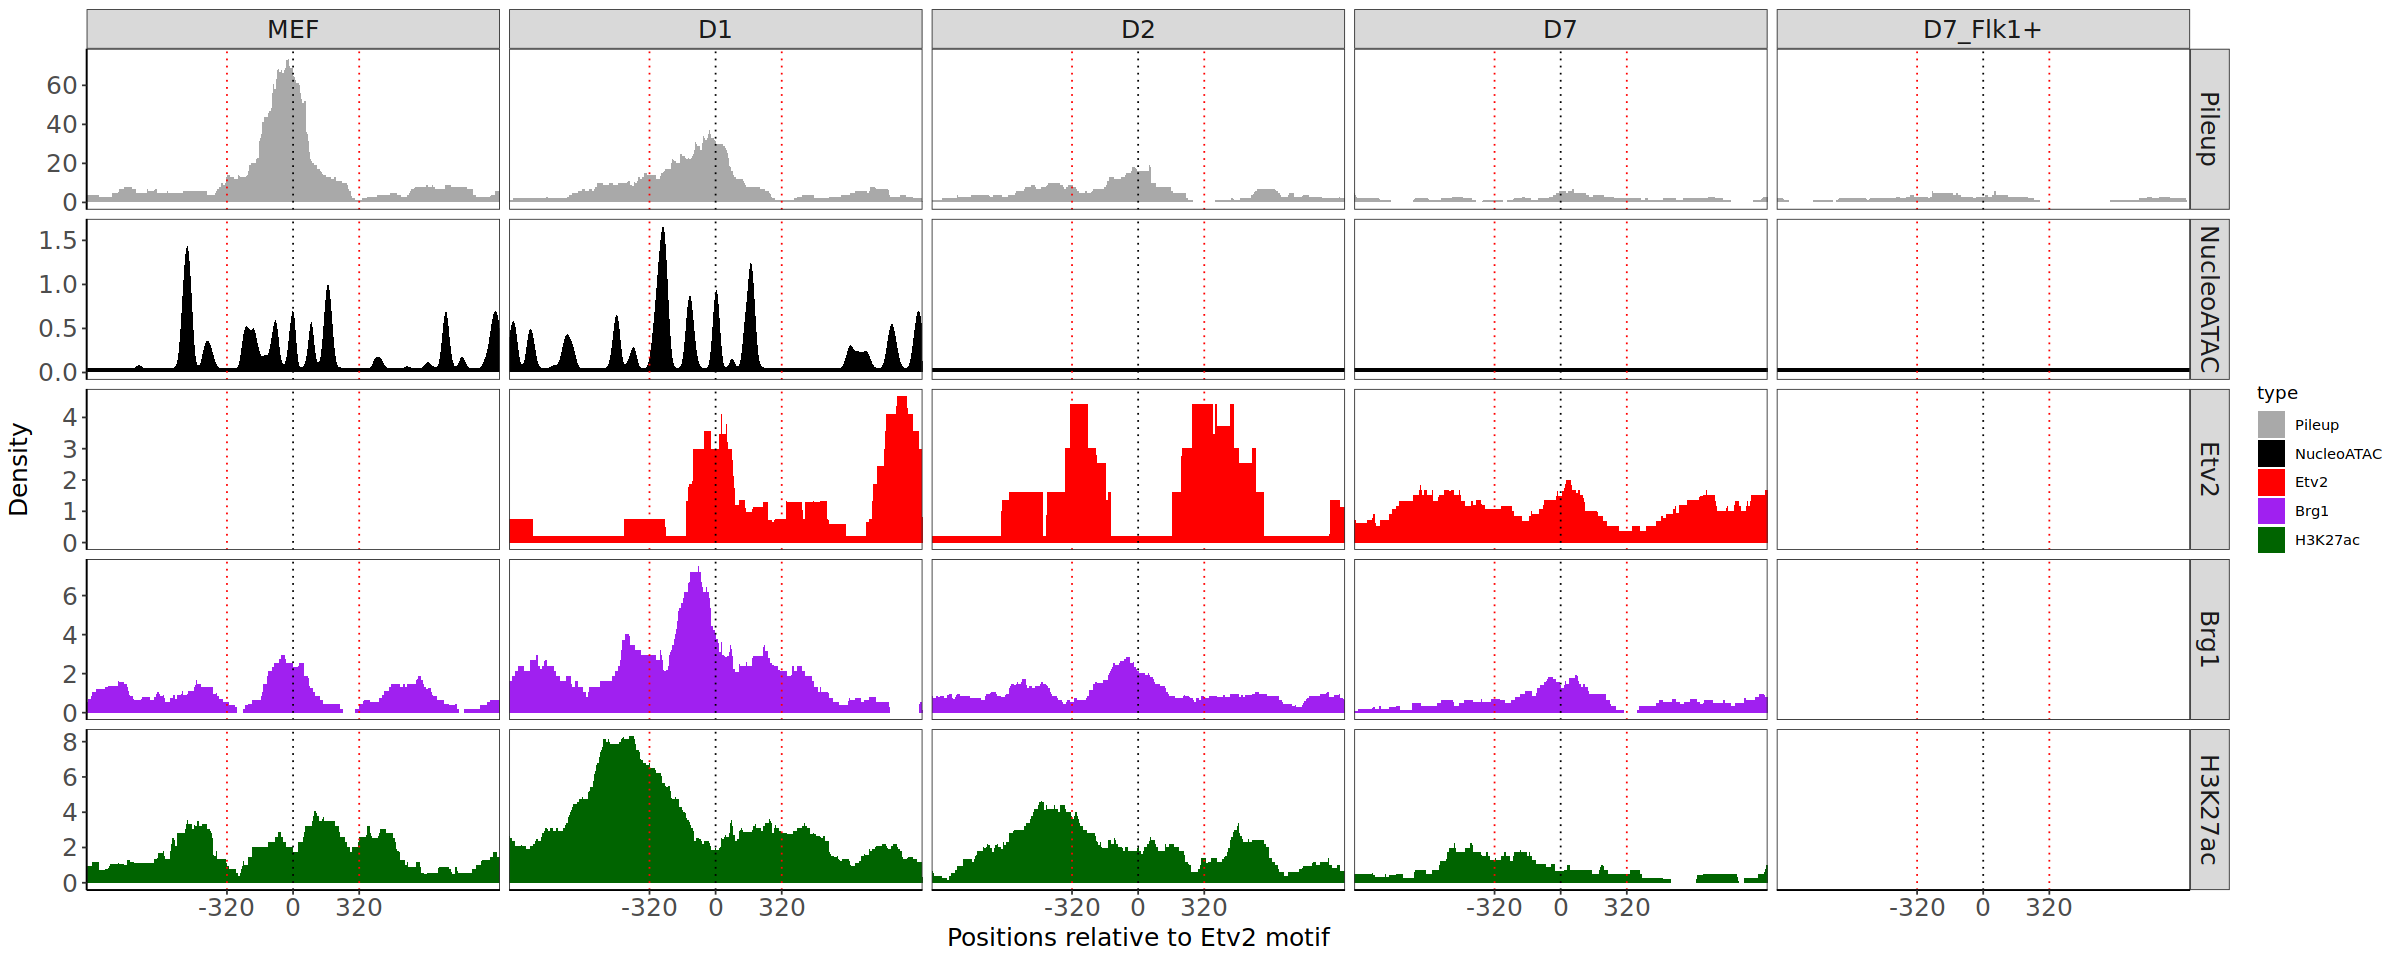

In [ ]:
options(repr.plot.width = 19.4, repr.plot.height = 4)
vplot(x2, 'counts', ncol = 5)
vplot(x2, 'predicted_counts', ncol = 5)
options(repr.plot.width = 20, repr.plot.height = 8)
plot_track(x2)

## SessionInfo

In [ ]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /panfs/jay/groups/18/garrydj/gongx030/.conda/envs/r421_py37_tf26/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] BSgenome.Hsapiens.UCSC.hg19_1.4.3        
 [2] BSgenome.Mmusculus.UCSC.mm10_1.4.3       
 [3] BSgenome_1.64.0                          
 [4] rtracklayer_1.56.1                       
 [5] Biostrings_2.64.1                        
 [6] XVector_0.36.0    